# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


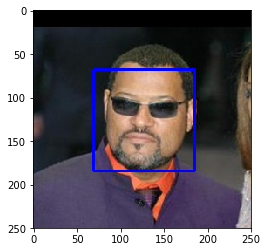

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_cnt = 0
for file in human_files_short:
    if face_detector(file):
        human_cnt += 1

dog_cnt = 0
for file in dog_files_short:
    if face_detector(file):
        dog_cnt += 1

print("Percentage of the first 100 images in human_files have a detected human face: {}%".format(human_cnt))
print("Percentage of the first 100 images in dog_files have a detected human face: {}%".format(dog_cnt))


Percentage of the first 100 images in human_files have a detected human face: 99%
Percentage of the first 100 images in dog_files have a detected human face: 11%


- The algorithm accuracy is acceptable and pretty high on the human dataset(99%) only one misdetection
- However, there is 11% chance that the algorithm detects a dog as a human

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [7]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

# Preprocess dataset
def resize_image(img_path):
    img = cv2.imread(img_path)
    return cv2.resize(img, (224, 224))

human_files_short_train = human_files[:1000]
human_files_short_valid = human_files[1000:1250]
human_files_short_test = human_files[1250:1450]

dog_files_short_train = train_files[:1000]
dog_files_short_valid = valid_files[:250]
dog_files_short_test = test_files[:200]


# Training set
humans_train = [resize_image(img).astype('float32')/255 for img in human_files_short_train]
human_labels_train = np.array([[1, 0]] * len(humans_train), dtype=np.float32)
dogs_train = [resize_image(img).astype('float32')/255 for img in dog_files_short_train]
dog_labels_train = np.array([[0, 1]] * len(dogs_train), dtype=np.float32)

X_train = np.concatenate((humans_train, dogs_train), axis=0)
y_train = np.concatenate((human_labels_train, dog_labels_train), axis=0)

# validation set
humans_valid = [resize_image(img).astype('float32')/255 for img in human_files_short_valid]
human_labels_valid = np.array([[1, 0]] * len(humans_valid), dtype=np.float32)
dogs_valid = [resize_image(img).astype('float32')/255 for img in dog_files_short_valid]
dog_labels_valid = np.array([[0, 1]] * len(dogs_valid), dtype=np.float32)

X_valid = np.concatenate((humans_valid, dogs_valid), axis=0)
y_valid = np.concatenate((human_labels_valid, dog_labels_valid), axis=0)

# testing set
humans_test = [resize_image(img).astype('float32')/255 for img in human_files_short_test]
human_labels_test = np.array([[1, 0]] * len(humans_test), dtype=np.float32)
dogs_test = [resize_image(img).astype('float32')/255 for img in dog_files_short_test]
dog_labels_test = np.array([[0, 1]] * len(dogs_test), dtype=np.float32)

X_test = np.concatenate((humans_test, dogs_test), axis=0)
y_test = np.concatenate((human_labels_test, dog_labels_test), axis=0)

In [8]:
print(X_train.shape, y_train.shape)

(2000, 224, 224, 3) (2000, 2)


In [9]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 2,354.0
Trainable params: 2,354.0
Non-trainable params: 0.0
_________________________________________________________________


In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from keras.callbacks import ModelCheckpoint  

epochs = 100

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.dog_human_classification.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 2000 samples, validate on 500 samples
Epoch 1/100
2000/2000 [==============================] - 43s - loss: 0.6580 - acc: 0.6135 - val_loss: 0.6244 - val_acc: 0.6400
Epoch 2/100
2000/2000 [==============================] - 44s - loss: 0.5815 - acc: 0.7190 - val_loss: 0.5351 - val_acc: 0.7660
Epoch 3/100
2000/2000 [==============================] - 44s - loss: 0.5258 - acc: 0.7540 - val_loss: 0.4826 - val_acc: 0.7840
Epoch 4/100
2000/2000 [==============================] - 43s - loss: 0.4759 - acc: 0.7990 - val_loss: 0.4416 - val_acc: 0.8160
Epoch 5/100
2000/2000 [==============================] - 43s - loss: 0.4306 - acc: 0.8255 - val_loss: 0.3803 - val_acc: 0.8860
Epoch 6/100
2000/2000 [==============================] - 44s - loss: 0.3901 - acc: 0.8510 - val_loss: 0.3484 - val_acc: 0.8820
Epoch 7/100
2000/2000 [==============================] - 42s - loss: 0.3619 - acc: 0.8625 - val_loss: 0.3136 - val_acc: 0.9120
Epoch 8/100
2000/2000 [==============================] - 42s - l

2000/2000 [==============================] - 47s - loss: 0.1631 - acc: 0.9380 - val_loss: 0.1689 - val_acc: 0.9540
Epoch 60/100
2000/2000 [==============================] - 48s - loss: 0.1574 - acc: 0.9445 - val_loss: 0.1611 - val_acc: 0.9560
Epoch 61/100
2000/2000 [==============================] - 48s - loss: 0.1536 - acc: 0.9475 - val_loss: 0.2452 - val_acc: 0.8960
Epoch 62/100
2000/2000 [==============================] - 48s - loss: 0.1566 - acc: 0.9430 - val_loss: 0.1996 - val_acc: 0.9400
Epoch 63/100
2000/2000 [==============================] - 47s - loss: 0.1565 - acc: 0.9380 - val_loss: 0.1893 - val_acc: 0.9460
Epoch 64/100
2000/2000 [==============================] - 47s - loss: 0.1601 - acc: 0.9460 - val_loss: 0.1853 - val_acc: 0.9460
Epoch 65/100
2000/2000 [==============================] - 48s - loss: 0.1474 - acc: 0.9470 - val_loss: 0.1487 - val_acc: 0.9680
Epoch 66/100
2000/2000 [==============================] - 47s - loss: 0.1509 - acc: 0.9465 - val_loss: 0.1821 - val_a

In [12]:
# Test
dog_human_predictions = [np.argmax(model.predict(np.expand_dims(test, axis=0))) for test in X_test]

test_accuracy = 100*np.sum(np.array(dog_human_predictions)==np.argmax(y_test, axis=1))/len(dog_human_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 95.2500%


In [13]:
def predict_dog_or_human(img_path):
    img = resize_image(img_path).astype('float32')/255
    human_or_dog = np.argmax(model.predict(np.expand_dims(img, axis=0)))
    
    if human_or_dog == 0:
        return "You are a human"
    if human_or_dog == 1:
        return "You are a dog"

In [14]:
from IPython.display import Image
from IPython.display import display

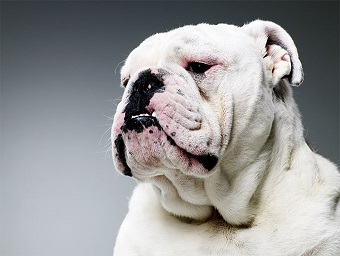

You are a dog


In [15]:
filename = './testImages/bulldog.jpg'
img = Image(filename) 
display(img)
print(predict_dog_or_human(filename))

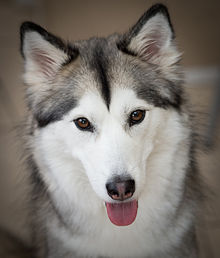

You are a human


In [16]:
filename = './testImages/siberian_husky.jpg'
img = Image(filename) 
display(img)
print(predict_dog_or_human(filename))

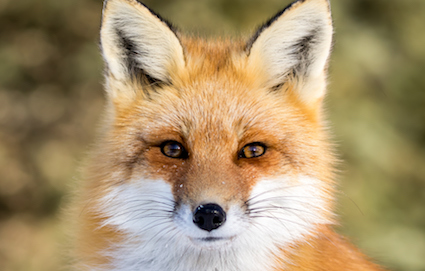

You are a human


In [17]:
filename = './testImages/fox.jpg'
img = Image(filename) 
display(img)
print(predict_dog_or_human(filename))

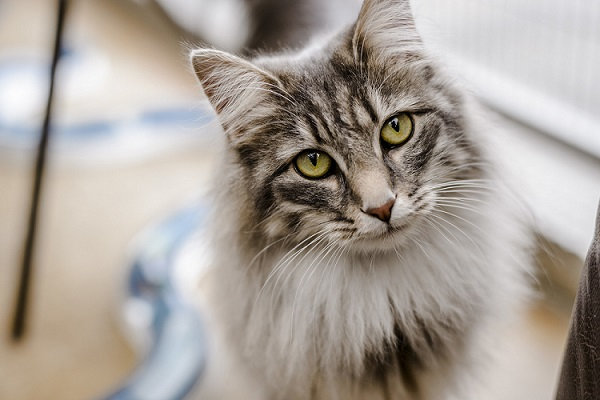

You are a dog


In [25]:
filename = './testImages/cat.jpg'
img = Image(filename) 
display(img)
print(predict_dog_or_human(filename))

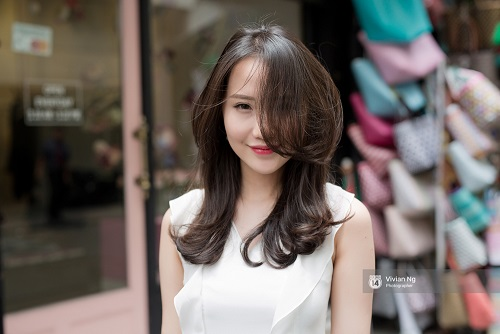

You are a dog


In [26]:
filename = './testImages/xuanthao.jpg'
img = Image(filename) 
display(img)
print(predict_dog_or_human(filename))

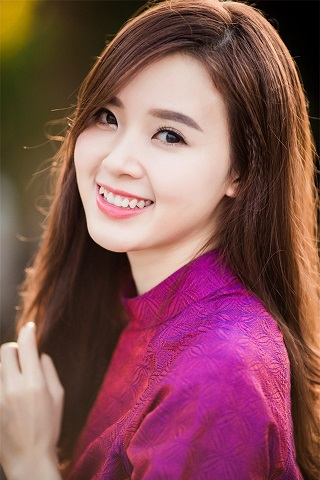

You are a dog


In [20]:
filename = './testImages/midu.jpg'
img = Image(filename) 
display(img)
print(predict_dog_or_human(filename))

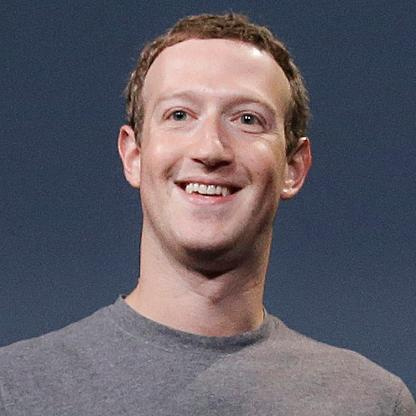

You are a human


In [23]:
filename = './testImages/mark.jpg'
img = Image(filename) 
display(img)
print(predict_dog_or_human(filename))

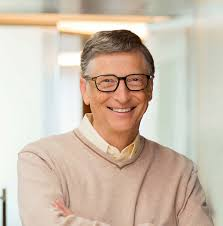

You are a human


In [29]:
filename = './testImages/bill.jpg'
img = Image(filename) 
display(img)
print(predict_dog_or_human(filename))

- Yes, it is reasonable to ensure the users to pose clear views of their faces. Otherwise, it would be rather difficult to extract the facial features.
- I try to build a dog/human classifier based on the provided dataset. It achieved a high accuracy (95.2500%) on the provided test set. But when I test with real images the algorithm seemed not to work well.
- I guess that is due to the overfiting to the training set. The false cases come with a full view of the body, and are asian girls. While some famous people I found on the Internet with a clear view of faces has been classified correctly 

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [30]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [31]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [32]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [33]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [36]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_cnt = 0
for file in human_files_short:
    if dog_detector(file):
        human_cnt += 1

dog_cnt = 0
for file in dog_files_short:
    if dog_detector(file):
        dog_cnt += 1

print("Percentage of the first 100 images in human_files have a detected dog: {}%".format(human_cnt))
print("Percentage of the first 100 images in dog_files have a detected dog: {}%".format(dog_cnt))

Percentage of the first 100 images in human_files have a detected dog: 1%
Percentage of the first 100 images in dog_files have a detected dog: 100%


- The dog detection algorithm work well on both dog and humnan dataset
- It can detect every dog and only misdetect 1 human as a dog

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [37]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255


 13%|█████▏                                 | 883/6680 [00:30<02:20, 41.23it/s]


 24%|████████▉                             | 1571/6680 [01:04<10:30,  8.10it/s]


 31%|███████████▊                          | 2078/6680 [01:47<02:34, 29.86it/s]


 46%|█████████████████▍                    | 3070/6680 [02:18<01:27, 41.25it/s]


 63%|███████████████████████▊              | 4182/6680 [02:47<00:51, 48.33it/s]


 75%|████████████████████████████▌         | 5013/6680 [03:21<01:30, 18.40it/s]


 90%|██████████████████████████████████    | 5981/6680 [03:54<00:23, 29.18it/s]


100%|██████████████████████████████████████| 6680/6680 [04:24<00:00, 21.63it/s]

  0%|                                                  | 0/835 [00:00<?, ?it/s]Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\dog-project\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\envs\dog-project\lib\site-packages\tqdm\_tqdm.py", line 109, in run
    if instance.miniters > 1 and \
AttributeError: 'tqdm' object has no attribute 'miniters'


  4%|█▍                                       | 30/835 [00:34<26:39,  1.99s/it]


 32%|████████████▋                           | 266/835 [02:35<01:09,  8.20it/s]


 82%|████████████████████████████████▊       | 685/835 [03:17<00:10, 13.70it/s]


100%|████████████████████████████████████████| 835/835 [03:24<00:00, 22.64it/s]

 41%|████████████████▎                       | 341/836 [00:28<00:35, 14.03it/s]


100%|████████████████████████████████████████| 836/836 [00:54<00:00, 15.31it/s]

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

- I choose the provided architecture above. It seems not working well. Only 1.1962% accuracy.
- The architecture consists of 3 Conv layers and 3 Pooling layers in between:
    + The first Conv layer take the input color images which are 3-D tensors and have the size of 224x224x3
    + Usually, The 1st Conv layer would be the generic feature classifier and the last layer would be the specific feature classifier layer. Therefore, I choose the number of filters increased by 16, 32, 64
    + The MaxPooling layers in between is to reduce the heavy lifting of each Conv layers (reduce the needed-to-optimize parameters) by downsampling the tensors.
    + Though we have 133 different dog breeds, the output is a normal Dense layer which have 133 outputs corresponding to 133 breeds.
- I think the architecture would work well on the dataset because we have been reduced the resolution of each image to 224x224 and moreover simple enough for a fast training session.

In [38]:
print(train_tensors.shape, train_targets.shape)

(6680, 224, 224, 3) (6680, 133)


In [74]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 111, 111, 32)      2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 55, 55, 64)        8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 64)                0         
__________

### Compile the Model

In [75]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [76]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10


6680/6680 [==============================] - 142s - loss: 8.8245 - acc: 0.0081 - val_loss: 8.6092 - val_acc: 0.0108
Epoch 2/10


4200/6680 [=================>............] - ETA: 133s - loss: 8.0590 - acc: 0.0000e+0 - ETA: 131s - loss: 6.8502 - acc: 0.0000e+0 - ETA: 135s - loss: 6.7159 - acc: 0.0000e+0 - ETA: 132s - loss: 7.2531 - acc: 0.0250    - ETA: 133s - loss: 6.9308 - acc: 0.030 - ETA: 132s - loss: 7.3875 - acc: 0.025 - ETA: 132s - loss: 7.4834 - acc: 0.021 - ETA: 131s - loss: 7.4546 - acc: 0.025 - ETA: 130s - loss: 7.4322 - acc: 0.033 - ETA: 129s - loss: 7.4949 - acc: 0.030 - ETA: 128s - loss: 7.6927 - acc: 0.031 - ETA: 128s - loss: 7.7233 - acc: 0.029 - ETA: 128s - loss: 7.8731 - acc: 0.026 - ETA: 128s - loss: 7.8864 - acc: 0.025 - ETA: 127s - loss: 8.0590 - acc: 0.023 - ETA: 126s - loss: 8.2605 - acc: 0.021 - ETA: 126s - loss: 8.1539 - acc: 0.020 - ETA: 125s - loss: 8.2381 - acc: 0.019 - ETA: 125s - loss: 8.2711 - acc: 0.018 - ETA: 125s - loss: 8.4620 - acc: 0.017 - ETA: 125s - loss: 8.3277 - acc: 0.016 - ETA: 124s - loss: 8.3887 - acc: 0.015 - ETA: 124s - loss: 8.4094 - acc: 0.015 - ETA: 123s - loss: 8

6680/6680 [==============================] - 142s - loss: 8.5995 - acc: 0.0109 - val_loss: 8.6092 - val_acc: 0.0108
Epoch 3/10


6680/6680 [==============================] - 145s - loss: 8.5995 - acc: 0.0109 - val_loss: 8.6092 - val_acc: 0.0108
Epoch 4/10


4180/6680 [=================>............] - ETA: 136s - loss: 7.2531 - acc: 0.0000e+0 - ETA: 139s - loss: 7.2531 - acc: 0.0000e+0 - ETA: 140s - loss: 7.5218 - acc: 0.0000e+0 - ETA: 140s - loss: 7.6561 - acc: 0.0000e+0 - ETA: 144s - loss: 7.4143 - acc: 0.0000e+0 - ETA: 145s - loss: 7.5218 - acc: 0.0000e+0 - ETA: 145s - loss: 7.7137 - acc: 0.0000e+0 - ETA: 144s - loss: 7.7568 - acc: 0.0063    - ETA: 144s - loss: 7.7009 - acc: 0.005 - ETA: 143s - loss: 8.1396 - acc: 0.005 - ETA: 142s - loss: 7.9858 - acc: 0.009 - ETA: 142s - loss: 7.8576 - acc: 0.008 - ETA: 141s - loss: 7.9971 - acc: 0.011 - ETA: 140s - loss: 8.1166 - acc: 0.010 - ETA: 140s - loss: 8.2202 - acc: 0.010 - ETA: 139s - loss: 8.3109 - acc: 0.009 - ETA: 138s - loss: 8.2961 - acc: 0.008 - ETA: 138s - loss: 8.3277 - acc: 0.008 - ETA: 138s - loss: 8.2711 - acc: 0.010 - ETA: 137s - loss: 8.2202 - acc: 0.010 - ETA: 136s - loss: 8.2509 - acc: 0.009 - ETA: 136s - loss: 8.3155 - acc: 0.009 - ETA: 135s - loss: 8.3394 - acc: 0.008 - ETA

6680/6680 [==============================] - 147s - loss: 8.5995 - acc: 0.0109 - val_loss: 8.6092 - val_acc: 0.0108
Epoch 5/10


6680/6680 [==============================] - 145s - loss: 8.5995 - acc: 0.0109 - val_loss: 8.6092 - val_acc: 0.0108
Epoch 6/10


4200/6680 [=================>............] - ETA: 152s - loss: 8.0590 - acc: 0.0000e+0 - ETA: 147s - loss: 8.4620 - acc: 0.0000e+0 - ETA: 143s - loss: 8.8650 - acc: 0.0000e+0 - ETA: 141s - loss: 8.8650 - acc: 0.0250    - ETA: 141s - loss: 8.5426 - acc: 0.020 - ETA: 140s - loss: 8.5963 - acc: 0.025 - ETA: 138s - loss: 8.5196 - acc: 0.021 - ETA: 137s - loss: 8.3613 - acc: 0.031 - ETA: 136s - loss: 8.4172 - acc: 0.027 - ETA: 136s - loss: 8.6232 - acc: 0.025 - ETA: 135s - loss: 8.4986 - acc: 0.022 - ETA: 134s - loss: 8.6635 - acc: 0.020 - ETA: 134s - loss: 8.9269 - acc: 0.023 - ETA: 134s - loss: 8.8650 - acc: 0.021 - ETA: 134s - loss: 8.7038 - acc: 0.023 - ETA: 133s - loss: 8.5627 - acc: 0.021 - ETA: 133s - loss: 8.6753 - acc: 0.020 - ETA: 132s - loss: 8.5963 - acc: 0.019 - ETA: 132s - loss: 8.6953 - acc: 0.018 - ETA: 131s - loss: 8.7441 - acc: 0.017 - ETA: 131s - loss: 8.5963 - acc: 0.016 - ETA: 130s - loss: 8.6452 - acc: 0.015 - ETA: 130s - loss: 8.5846 - acc: 0.015 - ETA: 130s - loss: 8

6680/6680 [==============================] - 146s - loss: 8.5995 - acc: 0.0109 - val_loss: 8.6092 - val_acc: 0.0108
Epoch 7/10


6680/6680 [==============================] - 147s - loss: 8.5995 - acc: 0.0109 - val_loss: 8.6092 - val_acc: 0.0108
Epoch 8/10


4200/6680 [=================>............] - ETA: 135s - loss: 7.2531 - acc: 0.050 - ETA: 136s - loss: 6.0443 - acc: 0.050 - ETA: 134s - loss: 7.2531 - acc: 0.050 - ETA: 134s - loss: 8.4620 - acc: 0.037 - ETA: 134s - loss: 8.0590 - acc: 0.030 - ETA: 137s - loss: 8.0590 - acc: 0.025 - ETA: 136s - loss: 8.7498 - acc: 0.021 - ETA: 137s - loss: 8.7642 - acc: 0.025 - ETA: 137s - loss: 8.8650 - acc: 0.022 - ETA: 137s - loss: 8.8650 - acc: 0.025 - ETA: 137s - loss: 9.1580 - acc: 0.022 - ETA: 136s - loss: 9.0664 - acc: 0.020 - ETA: 136s - loss: 8.8650 - acc: 0.023 - ETA: 136s - loss: 8.8650 - acc: 0.021 - ETA: 135s - loss: 8.8650 - acc: 0.023 - ETA: 135s - loss: 8.8650 - acc: 0.021 - ETA: 135s - loss: 8.8175 - acc: 0.020 - ETA: 135s - loss: 8.9097 - acc: 0.019 - ETA: 134s - loss: 8.9922 - acc: 0.018 - ETA: 133s - loss: 9.2276 - acc: 0.017 - ETA: 133s - loss: 9.2871 - acc: 0.016 - ETA: 132s - loss: 9.3778 - acc: 0.015 - ETA: 132s - loss: 9.2153 - acc: 0.015 - ETA: 131s - loss: 9.2679 - acc: 0.0

6680/6680 [==============================] - 144s - loss: 8.5995 - acc: 0.0109 - val_loss: 8.6092 - val_acc: 0.0108
Epoch 9/10


6680/6680 [==============================] - 145s - loss: 8.5995 - acc: 0.0109 - val_loss: 8.6092 - val_acc: 0.0108
Epoch 10/10


4160/6680 [=================>............] - ETA: 138s - loss: 12.0886 - acc: 0.0000e+ - ETA: 136s - loss: 9.6709 - acc: 0.0000e+00 - ETA: 135s - loss: 9.1336 - acc: 0.0000e+0 - ETA: 136s - loss: 9.4694 - acc: 0.0000e+0 - ETA: 135s - loss: 9.3485 - acc: 0.0000e+0 - ETA: 134s - loss: 9.2679 - acc: 0.0000e+0 - ETA: 134s - loss: 9.0952 - acc: 0.0000e+0 - ETA: 133s - loss: 8.8650 - acc: 0.0000e+0 - ETA: 133s - loss: 8.5963 - acc: 0.0000e+0 - ETA: 132s - loss: 8.2202 - acc: 0.0000e+0 - ETA: 132s - loss: 7.9125 - acc: 0.0000e+0 - ETA: 131s - loss: 7.8576 - acc: 0.0000e+0 - ETA: 131s - loss: 7.6251 - acc: 0.0000e+0 - ETA: 130s - loss: 7.8864 - acc: 0.0000e+0 - ETA: 130s - loss: 8.0590 - acc: 0.0000e+0 - ETA: 130s - loss: 7.9583 - acc: 0.0000e+0 - ETA: 129s - loss: 8.0590 - acc: 0.0000e+0 - ETA: 128s - loss: 8.1038 - acc: 0.0000e+0 - ETA: 128s - loss: 8.1015 - acc: 0.0000e+0 - ETA: 127s - loss: 8.0188 - acc: 0.0000e+0 - ETA: 127s - loss: 7.9055 - acc: 0.0024    - ETA: 126s - loss: 7.9492 - acc

6680/6680 [==============================] - 144s - loss: 8.5995 - acc: 0.0109 - val_loss: 8.6092 - val_acc: 0.0108


### Load the Model with the Best Validation Loss

In [77]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [78]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.1962%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [44]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [45]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [46]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [70]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s - loss: 7.3188 - acc: 0.5370 - val_loss: 7.9983 - val_acc: 0.4563
Epoch 2/20
6680/6680 [==============================] - 2s - loss: 7.2891 - acc: 0.5413 - val_loss: 7.9900 - val_acc: 0.4527
Epoch 3/20
6680/6680 [==============================] - 2s - loss: 7.2480 - acc: 0.5445 - val_loss: 7.9958 - val_acc: 0.4407
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 7.1750 - acc: 0.5467 - val_loss: 7.9354 - val_acc: 0.4479
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 7.1486 - acc: 0.5515 - val_loss: 7.8911 - val_acc: 0.4575
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 7.1298 - acc: 0.5540 - val_loss: 7.8883 - val_acc: 0.4635
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 7.0666 - acc: 0.5557 - val_loss: 7.8639 - val_acc: 0.4635
Epoch 8/20
6680/6680 [==============================] - 2s - loss: 7.0267 - ac

6680/6680 [==============================] - 2s - loss: 7.0025 - acc: 0.5638 - val_loss: 7.7526 - val_acc: 0.4611
Epoch 11/20
6680/6680 [==============================] - 2s - loss: 6.9416 - acc: 0.5647 - val_loss: 7.7312 - val_acc: 0.4611
Epoch 12/20
6680/6680 [==============================] - 1s - loss: 6.8985 - acc: 0.5684 - val_loss: 7.7079 - val_acc: 0.4623
Epoch 13/20
6680/6680 [==============================] - 2s - loss: 6.8872 - acc: 0.5704 - val_loss: 7.7481 - val_acc: 0.4647
Epoch 14/20
6680/6680 [==============================] - 1s - loss: 6.8798 - acc: 0.5719 - val_loss: 7.6862 - val_acc: 0.4731
Epoch 15/20
6680/6680 [==============================] - 2s - loss: 6.8552 - acc: 0.5720 - val_loss: 7.7295 - val_acc: 0.4599
Epoch 16/20
6680/6680 [==============================] - 1s - loss: 6.8227 - acc: 0.5720 - val_loss: 7.6894 - val_acc: 0.4671
Epoch 17/20
6680/6680 [==============================] - 2s - loss: 6.8091 - acc: 0.5728 - val_loss: 7.6609 - val_acc: 0.4659
Epoc

6680/6680 [==============================] - 2s - loss: 6.5569 - acc: 0.5892 - val_loss: 7.4558 - val_acc: 0.4766


### Load the Model with the Best Validation Loss

In [71]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [72]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 46.1722%


### Predict Dog Breed with the Model

In [50]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [51]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



- I try the original architectural design and it works well with the accuracy of 83.9713%
- I choose the original architecture without modifying because I think the Xception model is already complicated enough (272,517.0 parameters)
    + I just add a GlobalAveragePooling2D layer and the output Dense layer with having 133 outputs corresponding to 133 different dog breeds.
    + I choose the softmax activation function at the output layer because this is a classification problem so the softmax function would be suitable most

In [55]:
### TODO: Define your architecture.
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [56]:
### TODO: Compile the model.
Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [57]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Inc_model.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=2000, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/2000
6680/6680 [==============================] - 5s - loss: 1.0546 - acc: 0.7433 - val_loss: 0.5194 - val_acc: 0.8275
Epoch 2/2000
6680/6680 [==============================] - 5s - loss: 0.3985 - acc: 0.8728 - val_loss: 0.5044 - val_acc: 0.8371
Epoch 3/2000
6680/6680 [==============================] - 5s - loss: 0.3225 - acc: 0.8996 - val_loss: 0.4919 - val_acc: 0.8467
Epoch 4/2000
6680/6680 [==============================] - 5s - loss: 0.2792 - acc: 0.9129 - val_loss: 0.5105 - val_acc: 0.8479
Epoch 5/2000


6680/6680 [==============================] - 5s - loss: 0.2441 - acc: 0.9241 - val_loss: 0.5363 - val_acc: 0.8455
Epoch 6/2000
6680/6680 [==============================] - 5s - loss: 0.2196 - acc: 0.9326 - val_loss: 0.5024 - val_acc: 0.8659
Epoch 7/2000
6680/6680 [==============================] - 5s - loss: 0.1959 - acc: 0.9422 - val_loss: 0.5419 - val_acc: 0.8539
Epoch 8/2000
6680/6680 [==============================] - 5s - loss: 0.1738 - acc: 0.9460 - val_loss: 0.5780 - val_acc: 0.8563
Epoch 9/2000


6680/6680 [==============================] - 5s - loss: 0.1655 - acc: 0.9500 - val_loss: 0.5748 - val_acc: 0.8503
Epoch 10/2000
6680/6680 [==============================] - 4s - loss: 0.1479 - acc: 0.9570 - val_loss: 0.5822 - val_acc: 0.8611
Epoch 11/2000
6680/6680 [==============================] - 4s - loss: 0.1374 - acc: 0.9591 - val_loss: 0.5953 - val_acc: 0.8527
Epoch 12/2000
6680/6680 [==============================] - 4s - loss: 0.1262 - acc: 0.9609 - val_loss: 0.5953 - val_acc: 0.8515
Epoch 13/2000


6680/6680 [==============================] - 4s - loss: 0.1189 - acc: 0.9651 - val_loss: 0.6025 - val_acc: 0.8587
Epoch 14/2000
6680/6680 [==============================] - 4s - loss: 0.1124 - acc: 0.9662 - val_loss: 0.6274 - val_acc: 0.8503
Epoch 15/2000
6680/6680 [==============================] - 5s - loss: 0.1024 - acc: 0.9681 - val_loss: 0.6362 - val_acc: 0.8599
Epoch 16/2000
6680/6680 [==============================] - 5s - loss: 0.0930 - acc: 0.9722 - val_loss: 0.6614 - val_acc: 0.8503
Epoch 17/2000


6680/6680 [==============================] - 5s - loss: 0.0904 - acc: 0.9749 - val_loss: 0.6587 - val_acc: 0.8575
Epoch 18/2000
6680/6680 [==============================] - 5s - loss: 0.0847 - acc: 0.9763 - val_loss: 0.6546 - val_acc: 0.8527
Epoch 19/2000
6680/6680 [==============================] - 5s - loss: 0.0780 - acc: 0.9774 - val_loss: 0.6946 - val_acc: 0.8491
Epoch 20/2000
6680/6680 [==============================] - 5s - loss: 0.0737 - acc: 0.9780 - val_loss: 0.6782 - val_acc: 0.8599
Epoch 21/2000


6680/6680 [==============================] - 5s - loss: 0.0681 - acc: 0.9813 - val_loss: 0.7048 - val_acc: 0.8503
Epoch 22/2000
6680/6680 [==============================] - 5s - loss: 0.0675 - acc: 0.9805 - val_loss: 0.6999 - val_acc: 0.8599
Epoch 23/2000
6680/6680 [==============================] - 5s - loss: 0.0630 - acc: 0.9822 - val_loss: 0.7227 - val_acc: 0.8527
Epoch 24/2000
6680/6680 [==============================] - 5s - loss: 0.0585 - acc: 0.9834 - val_loss: 0.7255 - val_acc: 0.8611
Epoch 25/2000


6680/6680 [==============================] - 5s - loss: 0.0584 - acc: 0.9843 - val_loss: 0.7417 - val_acc: 0.8599
Epoch 26/2000
6680/6680 [==============================] - 5s - loss: 0.0522 - acc: 0.9853 - val_loss: 0.7618 - val_acc: 0.8563
Epoch 27/2000
6680/6680 [==============================] - 5s - loss: 0.0524 - acc: 0.9856 - val_loss: 0.7315 - val_acc: 0.8599
Epoch 28/2000
6680/6680 [==============================] - 5s - loss: 0.0462 - acc: 0.9862 - val_loss: 0.7845 - val_acc: 0.8563
Epoch 29/2000


6680/6680 [==============================] - 4s - loss: 0.0446 - acc: 0.9876 - val_loss: 0.7878 - val_acc: 0.8551
Epoch 30/2000
6680/6680 [==============================] - 4s - loss: 0.0439 - acc: 0.9867 - val_loss: 0.8172 - val_acc: 0.8515
Epoch 31/2000
6680/6680 [==============================] - 5s - loss: 0.0408 - acc: 0.9885 - val_loss: 0.7859 - val_acc: 0.8551
Epoch 32/2000
6680/6680 [==============================] - 4s - loss: 0.0400 - acc: 0.9885 - val_loss: 0.8156 - val_acc: 0.8539
Epoch 33/2000


6680/6680 [==============================] - 4s - loss: 0.0366 - acc: 0.9901 - val_loss: 0.8027 - val_acc: 0.8539
Epoch 34/2000
6680/6680 [==============================] - 4s - loss: 0.0357 - acc: 0.9895 - val_loss: 0.8554 - val_acc: 0.8539
Epoch 35/2000
6680/6680 [==============================] - 4s - loss: 0.0342 - acc: 0.9895 - val_loss: 0.8274 - val_acc: 0.8563
Epoch 36/2000
6680/6680 [==============================] - 5s - loss: 0.0327 - acc: 0.9909 - val_loss: 0.8823 - val_acc: 0.8539
Epoch 37/2000


6680/6680 [==============================] - 4s - loss: 0.0339 - acc: 0.9918 - val_loss: 0.8514 - val_acc: 0.8503
Epoch 38/2000
6680/6680 [==============================] - 5s - loss: 0.0314 - acc: 0.9910 - val_loss: 0.8925 - val_acc: 0.8551
Epoch 39/2000
6680/6680 [==============================] - 5s - loss: 0.0300 - acc: 0.9909 - val_loss: 0.8679 - val_acc: 0.8491
Epoch 40/2000
6680/6680 [==============================] - 4s - loss: 0.0297 - acc: 0.9912 - val_loss: 0.8822 - val_acc: 0.8575
Epoch 41/2000


6680/6680 [==============================] - 4s - loss: 0.0287 - acc: 0.9924 - val_loss: 0.9054 - val_acc: 0.8479
Epoch 42/2000
6680/6680 [==============================] - 4s - loss: 0.0277 - acc: 0.9927 - val_loss: 0.8968 - val_acc: 0.8491
Epoch 43/2000
6680/6680 [==============================] - 4s - loss: 0.0264 - acc: 0.9930 - val_loss: 0.9740 - val_acc: 0.8455
Epoch 44/2000
6680/6680 [==============================] - 5s - loss: 0.0258 - acc: 0.9933 - val_loss: 0.9199 - val_acc: 0.8563
Epoch 45/2000


6680/6680 [==============================] - 4s - loss: 0.0247 - acc: 0.9933 - val_loss: 0.9319 - val_acc: 0.8515
Epoch 46/2000
6680/6680 [==============================] - 5s - loss: 0.0241 - acc: 0.9934 - val_loss: 0.9332 - val_acc: 0.8479
Epoch 47/2000
6680/6680 [==============================] - 5s - loss: 0.0222 - acc: 0.9942 - val_loss: 0.9831 - val_acc: 0.8503
Epoch 48/2000
6680/6680 [==============================] - 5s - loss: 0.0239 - acc: 0.9937 - val_loss: 0.9625 - val_acc: 0.8467
Epoch 49/2000


6680/6680 [==============================] - 4s - loss: 0.0229 - acc: 0.9936 - val_loss: 0.9954 - val_acc: 0.8587
Epoch 50/2000
6680/6680 [==============================] - 5s - loss: 0.0221 - acc: 0.9939 - val_loss: 0.9854 - val_acc: 0.8539
Epoch 51/2000
6680/6680 [==============================] - 5s - loss: 0.0214 - acc: 0.9946 - val_loss: 1.0039 - val_acc: 0.8419
Epoch 52/2000
6680/6680 [==============================] - 4s - loss: 0.0217 - acc: 0.9939 - val_loss: 0.9766 - val_acc: 0.8491
Epoch 53/2000


6680/6680 [==============================] - 4s - loss: 0.0204 - acc: 0.9954 - val_loss: 1.0304 - val_acc: 0.8491
Epoch 54/2000
6680/6680 [==============================] - 4s - loss: 0.0200 - acc: 0.9951 - val_loss: 0.9905 - val_acc: 0.8491
Epoch 55/2000
6680/6680 [==============================] - 5s - loss: 0.0192 - acc: 0.9954 - val_loss: 1.0521 - val_acc: 0.8467
Epoch 56/2000
6680/6680 [==============================] - 5s - loss: 0.0191 - acc: 0.9955 - val_loss: 1.0345 - val_acc: 0.8479
Epoch 57/2000


6680/6680 [==============================] - 5s - loss: 0.0184 - acc: 0.9961 - val_loss: 1.0300 - val_acc: 0.8467
Epoch 58/2000
6680/6680 [==============================] - 5s - loss: 0.0185 - acc: 0.9951 - val_loss: 1.0681 - val_acc: 0.8467
Epoch 59/2000
6680/6680 [==============================] - 5s - loss: 0.0175 - acc: 0.9955 - val_loss: 1.0595 - val_acc: 0.8491
Epoch 60/2000
6680/6680 [==============================] - 5s - loss: 0.0172 - acc: 0.9958 - val_loss: 1.0527 - val_acc: 0.8491
Epoch 61/2000


6680/6680 [==============================] - 5s - loss: 0.0179 - acc: 0.9967 - val_loss: 1.0824 - val_acc: 0.8407
Epoch 62/2000
6680/6680 [==============================] - 5s - loss: 0.0154 - acc: 0.9964 - val_loss: 1.0658 - val_acc: 0.8491
Epoch 63/2000
6680/6680 [==============================] - 5s - loss: 0.0168 - acc: 0.9967 - val_loss: 1.0861 - val_acc: 0.8455
Epoch 64/2000
6680/6680 [==============================] - 5s - loss: 0.0161 - acc: 0.9969 - val_loss: 1.0716 - val_acc: 0.8395
Epoch 65/2000


6680/6680 [==============================] - 5s - loss: 0.0152 - acc: 0.9969 - val_loss: 1.1012 - val_acc: 0.8491
Epoch 66/2000
6680/6680 [==============================] - 5s - loss: 0.0161 - acc: 0.9967 - val_loss: 1.0906 - val_acc: 0.8479
Epoch 67/2000
6680/6680 [==============================] - 5s - loss: 0.0150 - acc: 0.9967 - val_loss: 1.1033 - val_acc: 0.8539
Epoch 68/2000
6680/6680 [==============================] - 5s - loss: 0.0147 - acc: 0.9975 - val_loss: 1.0831 - val_acc: 0.8515
Epoch 69/2000


6680/6680 [==============================] - 5s - loss: 0.0147 - acc: 0.9972 - val_loss: 1.1040 - val_acc: 0.8443
Epoch 70/2000
6680/6680 [==============================] - 5s - loss: 0.0155 - acc: 0.9972 - val_loss: 1.1187 - val_acc: 0.8407
Epoch 71/2000
6680/6680 [==============================] - 5s - loss: 0.0142 - acc: 0.9973 - val_loss: 1.1317 - val_acc: 0.8443
Epoch 72/2000
6680/6680 [==============================] - 5s - loss: 0.0153 - acc: 0.9976 - val_loss: 1.1288 - val_acc: 0.8431
Epoch 73/2000


6680/6680 [==============================] - 5s - loss: 0.0142 - acc: 0.9978 - val_loss: 1.1144 - val_acc: 0.8407
Epoch 74/2000
6680/6680 [==============================] - 5s - loss: 0.0142 - acc: 0.9975 - val_loss: 1.1694 - val_acc: 0.8383
Epoch 75/2000
6680/6680 [==============================] - 5s - loss: 0.0136 - acc: 0.9973 - val_loss: 1.1739 - val_acc: 0.8407
Epoch 76/2000
6680/6680 [==============================] - 5s - loss: 0.0129 - acc: 0.9976 - val_loss: 1.1669 - val_acc: 0.8395
Epoch 77/2000


6680/6680 [==============================] - 5s - loss: 0.0137 - acc: 0.9972 - val_loss: 1.1705 - val_acc: 0.8419
Epoch 78/2000
6680/6680 [==============================] - 5s - loss: 0.0133 - acc: 0.9981 - val_loss: 1.1647 - val_acc: 0.8419
Epoch 79/2000
6680/6680 [==============================] - 5s - loss: 0.0128 - acc: 0.9979 - val_loss: 1.1789 - val_acc: 0.8443
Epoch 80/2000
6680/6680 [==============================] - 5s - loss: 0.0136 - acc: 0.9979 - val_loss: 1.1674 - val_acc: 0.8383
Epoch 81/2000


6680/6680 [==============================] - 5s - loss: 0.0132 - acc: 0.9979 - val_loss: 1.2005 - val_acc: 0.8395
Epoch 82/2000
6680/6680 [==============================] - 5s - loss: 0.0131 - acc: 0.9978 - val_loss: 1.1670 - val_acc: 0.8407
Epoch 83/2000
6680/6680 [==============================] - 5s - loss: 0.0122 - acc: 0.9978 - val_loss: 1.1933 - val_acc: 0.8395
Epoch 84/2000
6680/6680 [==============================] - 5s - loss: 0.0125 - acc: 0.9984 - val_loss: 1.2168 - val_acc: 0.8347
Epoch 85/2000


6680/6680 [==============================] - 5s - loss: 0.0125 - acc: 0.9979 - val_loss: 1.2198 - val_acc: 0.8371
Epoch 86/2000
6680/6680 [==============================] - 5s - loss: 0.0125 - acc: 0.9982 - val_loss: 1.2028 - val_acc: 0.8371
Epoch 87/2000
6680/6680 [==============================] - 5s - loss: 0.0134 - acc: 0.9982 - val_loss: 1.2162 - val_acc: 0.8407
Epoch 88/2000
6680/6680 [==============================] - 5s - loss: 0.0123 - acc: 0.9982 - val_loss: 1.2182 - val_acc: 0.8383
Epoch 89/2000


6680/6680 [==============================] - 5s - loss: 0.0134 - acc: 0.9982 - val_loss: 1.2344 - val_acc: 0.8383
Epoch 90/2000
6680/6680 [==============================] - 5s - loss: 0.0130 - acc: 0.9979 - val_loss: 1.2564 - val_acc: 0.8383
Epoch 91/2000
6680/6680 [==============================] - 5s - loss: 0.0122 - acc: 0.9984 - val_loss: 1.2571 - val_acc: 0.8359
Epoch 92/2000
6680/6680 [==============================] - 5s - loss: 0.0123 - acc: 0.9985 - val_loss: 1.2206 - val_acc: 0.8395
Epoch 93/2000


6680/6680 [==============================] - 5s - loss: 0.0123 - acc: 0.9981 - val_loss: 1.2392 - val_acc: 0.8383
Epoch 94/2000
6680/6680 [==============================] - 5s - loss: 0.0119 - acc: 0.9982 - val_loss: 1.2605 - val_acc: 0.8359
Epoch 95/2000
6680/6680 [==============================] - 5s - loss: 0.0123 - acc: 0.9985 - val_loss: 1.2654 - val_acc: 0.8311
Epoch 96/2000
6680/6680 [==============================] - 5s - loss: 0.0122 - acc: 0.9985 - val_loss: 1.2549 - val_acc: 0.8311
Epoch 97/2000


6680/6680 [==============================] - 5s - loss: 0.0135 - acc: 0.9985 - val_loss: 1.2712 - val_acc: 0.8395
Epoch 98/2000
6680/6680 [==============================] - 5s - loss: 0.0130 - acc: 0.9982 - val_loss: 1.2637 - val_acc: 0.8395
Epoch 99/2000
6680/6680 [==============================] - 5s - loss: 0.0127 - acc: 0.9985 - val_loss: 1.2430 - val_acc: 0.8347
Epoch 100/2000
6680/6680 [==============================] - 5s - loss: 0.0126 - acc: 0.9984 - val_loss: 1.2893 - val_acc: 0.8359
Epoch 101/2000


6680/6680 [==============================] - 5s - loss: 0.0116 - acc: 0.9985 - val_loss: 1.2639 - val_acc: 0.8371
Epoch 102/2000
6680/6680 [==============================] - 5s - loss: 0.0120 - acc: 0.9985 - val_loss: 1.2933 - val_acc: 0.8359
Epoch 103/2000
6680/6680 [==============================] - 5s - loss: 0.0122 - acc: 0.9985 - val_loss: 1.2722 - val_acc: 0.8383
Epoch 104/2000
6680/6680 [==============================] - 5s - loss: 0.0113 - acc: 0.9981 - val_loss: 1.2640 - val_acc: 0.8383
Epoch 105/2000


6680/6680 [==============================] - 5s - loss: 0.0123 - acc: 0.9984 - val_loss: 1.2801 - val_acc: 0.8371
Epoch 106/2000
6680/6680 [==============================] - 5s - loss: 0.0122 - acc: 0.9988 - val_loss: 1.2927 - val_acc: 0.8383
Epoch 107/2000
6680/6680 [==============================] - 5s - loss: 0.0114 - acc: 0.9985 - val_loss: 1.2889 - val_acc: 0.8347
Epoch 108/2000
6680/6680 [==============================] - 5s - loss: 0.0112 - acc: 0.9985 - val_loss: 1.3227 - val_acc: 0.8299
Epoch 109/2000


6680/6680 [==============================] - 5s - loss: 0.0121 - acc: 0.9984 - val_loss: 1.3032 - val_acc: 0.8407
Epoch 110/2000
6680/6680 [==============================] - 5s - loss: 0.0126 - acc: 0.9985 - val_loss: 1.3369 - val_acc: 0.8323
Epoch 111/2000
6680/6680 [==============================] - 5s - loss: 0.0117 - acc: 0.9985 - val_loss: 1.3384 - val_acc: 0.8335
Epoch 112/2000
6680/6680 [==============================] - 5s - loss: 0.0118 - acc: 0.9985 - val_loss: 1.3226 - val_acc: 0.8347
Epoch 113/2000


6680/6680 [==============================] - 5s - loss: 0.0119 - acc: 0.9984 - val_loss: 1.3352 - val_acc: 0.8407
Epoch 114/2000
6680/6680 [==============================] - 5s - loss: 0.0115 - acc: 0.9987 - val_loss: 1.3319 - val_acc: 0.8359
Epoch 115/2000
6680/6680 [==============================] - 5s - loss: 0.0110 - acc: 0.9988 - val_loss: 1.3316 - val_acc: 0.8395
Epoch 116/2000
6680/6680 [==============================] - 5s - loss: 0.0122 - acc: 0.9982 - val_loss: 1.3283 - val_acc: 0.8347
Epoch 117/2000


6680/6680 [==============================] - 5s - loss: 0.0119 - acc: 0.9984 - val_loss: 1.3173 - val_acc: 0.8335
Epoch 118/2000
6680/6680 [==============================] - 5s - loss: 0.0112 - acc: 0.9988 - val_loss: 1.3357 - val_acc: 0.8383
Epoch 119/2000
6680/6680 [==============================] - 5s - loss: 0.0127 - acc: 0.9985 - val_loss: 1.3438 - val_acc: 0.8359
Epoch 120/2000
6680/6680 [==============================] - 5s - loss: 0.0124 - acc: 0.9985 - val_loss: 1.3374 - val_acc: 0.8335
Epoch 121/2000


6680/6680 [==============================] - 5s - loss: 0.0121 - acc: 0.9987 - val_loss: 1.3618 - val_acc: 0.8335
Epoch 122/2000
6680/6680 [==============================] - 5s - loss: 0.0130 - acc: 0.9987 - val_loss: 1.3650 - val_acc: 0.8335
Epoch 123/2000
6680/6680 [==============================] - 5s - loss: 0.0117 - acc: 0.9988 - val_loss: 1.3667 - val_acc: 0.8371
Epoch 124/2000
6680/6680 [==============================] - 5s - loss: 0.0116 - acc: 0.9990 - val_loss: 1.3624 - val_acc: 0.8335
Epoch 125/2000


6680/6680 [==============================] - 5s - loss: 0.0117 - acc: 0.9984 - val_loss: 1.3334 - val_acc: 0.8359
Epoch 126/2000
6680/6680 [==============================] - 5s - loss: 0.0121 - acc: 0.9985 - val_loss: 1.3703 - val_acc: 0.8287
Epoch 127/2000
6680/6680 [==============================] - 5s - loss: 0.0118 - acc: 0.9985 - val_loss: 1.3753 - val_acc: 0.8395
Epoch 128/2000
6680/6680 [==============================] - 5s - loss: 0.0119 - acc: 0.9987 - val_loss: 1.3548 - val_acc: 0.8311
Epoch 129/2000


6680/6680 [==============================] - 5s - loss: 0.0121 - acc: 0.9985 - val_loss: 1.3710 - val_acc: 0.8335
Epoch 130/2000
6680/6680 [==============================] - 5s - loss: 0.0120 - acc: 0.9984 - val_loss: 1.3918 - val_acc: 0.8335
Epoch 131/2000
6680/6680 [==============================] - 5s - loss: 0.0114 - acc: 0.9987 - val_loss: 1.3774 - val_acc: 0.8323
Epoch 132/2000
6680/6680 [==============================] - 5s - loss: 0.0111 - acc: 0.9987 - val_loss: 1.3482 - val_acc: 0.8335
Epoch 133/2000


6680/6680 [==============================] - 5s - loss: 0.0111 - acc: 0.9988 - val_loss: 1.3782 - val_acc: 0.8323
Epoch 134/2000
6680/6680 [==============================] - 5s - loss: 0.0114 - acc: 0.9987 - val_loss: 1.3761 - val_acc: 0.8323
Epoch 135/2000
6680/6680 [==============================] - 5s - loss: 0.0118 - acc: 0.9985 - val_loss: 1.3871 - val_acc: 0.8359
Epoch 136/2000
6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9988 - val_loss: 1.4091 - val_acc: 0.8323
Epoch 137/2000


6680/6680 [==============================] - 5s - loss: 0.0108 - acc: 0.9988 - val_loss: 1.3827 - val_acc: 0.8323
Epoch 138/2000
6680/6680 [==============================] - 5s - loss: 0.0109 - acc: 0.9990 - val_loss: 1.4140 - val_acc: 0.8311
Epoch 139/2000
6680/6680 [==============================] - 5s - loss: 0.0112 - acc: 0.9987 - val_loss: 1.4071 - val_acc: 0.8299
Epoch 140/2000
6680/6680 [==============================] - 5s - loss: 0.0116 - acc: 0.9988 - val_loss: 1.4003 - val_acc: 0.8347
Epoch 141/2000


6680/6680 [==============================] - 5s - loss: 0.0112 - acc: 0.9985 - val_loss: 1.4154 - val_acc: 0.8299
Epoch 142/2000
6680/6680 [==============================] - 5s - loss: 0.0107 - acc: 0.9988 - val_loss: 1.4028 - val_acc: 0.8311
Epoch 143/2000
6680/6680 [==============================] - 5s - loss: 0.0121 - acc: 0.9984 - val_loss: 1.4024 - val_acc: 0.8323
Epoch 144/2000
6680/6680 [==============================] - 5s - loss: 0.0112 - acc: 0.9988 - val_loss: 1.4010 - val_acc: 0.8287
Epoch 145/2000


6680/6680 [==============================] - 5s - loss: 0.0122 - acc: 0.9988 - val_loss: 1.4122 - val_acc: 0.8323
Epoch 146/2000
6680/6680 [==============================] - 5s - loss: 0.0118 - acc: 0.9985 - val_loss: 1.3984 - val_acc: 0.8299
Epoch 147/2000
6680/6680 [==============================] - 5s - loss: 0.0109 - acc: 0.9985 - val_loss: 1.4148 - val_acc: 0.8323
Epoch 148/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9990 - val_loss: 1.4069 - val_acc: 0.8299
Epoch 149/2000


6680/6680 [==============================] - 5s - loss: 0.0110 - acc: 0.9987 - val_loss: 1.3905 - val_acc: 0.8371
Epoch 150/2000
6680/6680 [==============================] - 5s - loss: 0.0112 - acc: 0.9987 - val_loss: 1.4194 - val_acc: 0.8311
Epoch 151/2000
6680/6680 [==============================] - 5s - loss: 0.0112 - acc: 0.9988 - val_loss: 1.4227 - val_acc: 0.8299
Epoch 152/2000
6680/6680 [==============================] - 5s - loss: 0.0109 - acc: 0.9987 - val_loss: 1.4053 - val_acc: 0.8287
Epoch 153/2000


6680/6680 [==============================] - 5s - loss: 0.0111 - acc: 0.9987 - val_loss: 1.4187 - val_acc: 0.8287
Epoch 154/2000
6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9985 - val_loss: 1.4245 - val_acc: 0.8335
Epoch 155/2000
6680/6680 [==============================] - 5s - loss: 0.0111 - acc: 0.9988 - val_loss: 1.4365 - val_acc: 0.8299
Epoch 156/2000
6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9987 - val_loss: 1.4321 - val_acc: 0.8311
Epoch 157/2000


6680/6680 [==============================] - 5s - loss: 0.0114 - acc: 0.9990 - val_loss: 1.4458 - val_acc: 0.8323
Epoch 158/2000
6680/6680 [==============================] - 5s - loss: 0.0117 - acc: 0.9987 - val_loss: 1.4406 - val_acc: 0.8323
Epoch 159/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9987 - val_loss: 1.4690 - val_acc: 0.8251
Epoch 160/2000
6680/6680 [==============================] - 5s - loss: 0.0111 - acc: 0.9985 - val_loss: 1.4286 - val_acc: 0.8299
Epoch 161/2000


6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9988 - val_loss: 1.4281 - val_acc: 0.8287
Epoch 162/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.4461 - val_acc: 0.8299
Epoch 163/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9988 - val_loss: 1.4646 - val_acc: 0.8287
Epoch 164/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9984 - val_loss: 1.4407 - val_acc: 0.8299
Epoch 165/2000


6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.4372 - val_acc: 0.8323
Epoch 166/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.4609 - val_acc: 0.8323
Epoch 167/2000
6680/6680 [==============================] - 5s - loss: 0.0108 - acc: 0.9987 - val_loss: 1.4537 - val_acc: 0.8299
Epoch 168/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9987 - val_loss: 1.4533 - val_acc: 0.8287
Epoch 169/2000


6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9988 - val_loss: 1.4557 - val_acc: 0.8299
Epoch 170/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9988 - val_loss: 1.4568 - val_acc: 0.8275
Epoch 171/2000
6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9987 - val_loss: 1.4651 - val_acc: 0.8275
Epoch 172/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9987 - val_loss: 1.4475 - val_acc: 0.8323
Epoch 173/2000


6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9990 - val_loss: 1.4336 - val_acc: 0.8287
Epoch 174/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9985 - val_loss: 1.4680 - val_acc: 0.8263
Epoch 175/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9990 - val_loss: 1.4784 - val_acc: 0.8287
Epoch 176/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9987 - val_loss: 1.4778 - val_acc: 0.8311
Epoch 177/2000


6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9988 - val_loss: 1.4544 - val_acc: 0.8275
Epoch 178/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9990 - val_loss: 1.4701 - val_acc: 0.8323
Epoch 179/2000
6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9985 - val_loss: 1.4685 - val_acc: 0.8263
Epoch 180/2000
6680/6680 [==============================] - 5s - loss: 0.0108 - acc: 0.9985 - val_loss: 1.4569 - val_acc: 0.8275
Epoch 181/2000


6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9988 - val_loss: 1.4777 - val_acc: 0.8299
Epoch 182/2000
6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9988 - val_loss: 1.4900 - val_acc: 0.8287
Epoch 183/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9987 - val_loss: 1.4648 - val_acc: 0.8275
Epoch 184/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9990 - val_loss: 1.4767 - val_acc: 0.8287
Epoch 185/2000


6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9990 - val_loss: 1.4752 - val_acc: 0.8335
Epoch 186/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9985 - val_loss: 1.4807 - val_acc: 0.8275
Epoch 187/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9988 - val_loss: 1.4688 - val_acc: 0.8335
Epoch 188/2000
6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9987 - val_loss: 1.4762 - val_acc: 0.8287
Epoch 189/2000


6680/6680 [==============================] - 5s - loss: 0.0108 - acc: 0.9985 - val_loss: 1.4806 - val_acc: 0.8311
Epoch 190/2000
6680/6680 [==============================] - 5s - loss: 0.0110 - acc: 0.9988 - val_loss: 1.4822 - val_acc: 0.8287
Epoch 191/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9987 - val_loss: 1.4801 - val_acc: 0.8275
Epoch 192/2000
6680/6680 [==============================] - 5s - loss: 0.0104 - acc: 0.9988 - val_loss: 1.5028 - val_acc: 0.8311
Epoch 193/2000


6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9987 - val_loss: 1.4781 - val_acc: 0.8311
Epoch 194/2000
6680/6680 [==============================] - 5s - loss: 0.0108 - acc: 0.9988 - val_loss: 1.4866 - val_acc: 0.8299
Epoch 195/2000
6680/6680 [==============================] - 5s - loss: 0.0107 - acc: 0.9987 - val_loss: 1.4868 - val_acc: 0.8287
Epoch 196/2000
6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9987 - val_loss: 1.4962 - val_acc: 0.8263
Epoch 197/2000


6680/6680 [==============================] - 5s - loss: 0.0107 - acc: 0.9987 - val_loss: 1.4897 - val_acc: 0.8251
Epoch 198/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9987 - val_loss: 1.4949 - val_acc: 0.8251
Epoch 199/2000
6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9985 - val_loss: 1.4905 - val_acc: 0.8275
Epoch 200/2000
6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9985 - val_loss: 1.4815 - val_acc: 0.8299
Epoch 201/2000


6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9985 - val_loss: 1.4991 - val_acc: 0.8287
Epoch 202/2000
6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9988 - val_loss: 1.5072 - val_acc: 0.8263
Epoch 203/2000
6680/6680 [==============================] - 5s - loss: 0.0104 - acc: 0.9985 - val_loss: 1.4908 - val_acc: 0.8263
Epoch 204/2000
6680/6680 [==============================] - 5s - loss: 0.0110 - acc: 0.9985 - val_loss: 1.4903 - val_acc: 0.8287
Epoch 205/2000


6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9988 - val_loss: 1.4855 - val_acc: 0.8299
Epoch 206/2000
6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9985 - val_loss: 1.4883 - val_acc: 0.8311
Epoch 207/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9987 - val_loss: 1.4970 - val_acc: 0.8299
Epoch 208/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9985 - val_loss: 1.5217 - val_acc: 0.8275
Epoch 209/2000


6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5129 - val_acc: 0.8263
Epoch 210/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.4966 - val_acc: 0.8263
Epoch 211/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9988 - val_loss: 1.4975 - val_acc: 0.8275
Epoch 212/2000
6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9987 - val_loss: 1.4982 - val_acc: 0.8287
Epoch 213/2000


6680/6680 [==============================] - 5s - loss: 0.0108 - acc: 0.9987 - val_loss: 1.5007 - val_acc: 0.8299
Epoch 214/2000
6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9985 - val_loss: 1.5017 - val_acc: 0.8287
Epoch 215/2000
6680/6680 [==============================] - 5s - loss: 0.0110 - acc: 0.9987 - val_loss: 1.5085 - val_acc: 0.8287
Epoch 216/2000
6680/6680 [==============================] - 5s - loss: 0.0107 - acc: 0.9985 - val_loss: 1.4999 - val_acc: 0.8287
Epoch 217/2000


6680/6680 [==============================] - 5s - loss: 0.0107 - acc: 0.9987 - val_loss: 1.5018 - val_acc: 0.8311
Epoch 218/2000
6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9988 - val_loss: 1.5136 - val_acc: 0.8263
Epoch 219/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9987 - val_loss: 1.5107 - val_acc: 0.8263
Epoch 220/2000
6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9990 - val_loss: 1.4974 - val_acc: 0.8275
Epoch 221/2000


6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9988 - val_loss: 1.5096 - val_acc: 0.8263
Epoch 222/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9985 - val_loss: 1.5152 - val_acc: 0.8287
Epoch 223/2000
6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9990 - val_loss: 1.5013 - val_acc: 0.8287
Epoch 224/2000
6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9985 - val_loss: 1.5118 - val_acc: 0.8287
Epoch 225/2000


6680/6680 [==============================] - 5s - loss: 0.0109 - acc: 0.9990 - val_loss: 1.5018 - val_acc: 0.8263
Epoch 226/2000
6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9987 - val_loss: 1.5055 - val_acc: 0.8263
Epoch 227/2000
6680/6680 [==============================] - 5s - loss: 0.0107 - acc: 0.9987 - val_loss: 1.5071 - val_acc: 0.8287
Epoch 228/2000
6680/6680 [==============================] - 5s - loss: 0.0109 - acc: 0.9990 - val_loss: 1.4989 - val_acc: 0.8287
Epoch 229/2000


6680/6680 [==============================] - 5s - loss: 0.0110 - acc: 0.9987 - val_loss: 1.5151 - val_acc: 0.8263
Epoch 230/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9988 - val_loss: 1.5263 - val_acc: 0.8263
Epoch 231/2000
6680/6680 [==============================] - 5s - loss: 0.0104 - acc: 0.9990 - val_loss: 1.5045 - val_acc: 0.8263
Epoch 232/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9988 - val_loss: 1.5000 - val_acc: 0.8275
Epoch 233/2000


6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9988 - val_loss: 1.5051 - val_acc: 0.8275
Epoch 234/2000
6680/6680 [==============================] - 5s - loss: 0.0108 - acc: 0.9988 - val_loss: 1.5124 - val_acc: 0.8263
Epoch 235/2000
6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9987 - val_loss: 1.5120 - val_acc: 0.8287
Epoch 236/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9987 - val_loss: 1.5055 - val_acc: 0.8275
Epoch 237/2000


6680/6680 [==============================] - 5s - loss: 0.0104 - acc: 0.9988 - val_loss: 1.5096 - val_acc: 0.8263
Epoch 238/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9985 - val_loss: 1.5035 - val_acc: 0.8311
Epoch 239/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9990 - val_loss: 1.5112 - val_acc: 0.8287
Epoch 240/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9990 - val_loss: 1.5140 - val_acc: 0.8275
Epoch 241/2000


6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9987 - val_loss: 1.5117 - val_acc: 0.8287
Epoch 242/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9987 - val_loss: 1.5081 - val_acc: 0.8299
Epoch 243/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9988 - val_loss: 1.5145 - val_acc: 0.8311
Epoch 244/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9987 - val_loss: 1.5231 - val_acc: 0.8275
Epoch 245/2000


6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9984 - val_loss: 1.5170 - val_acc: 0.8287
Epoch 246/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9988 - val_loss: 1.5188 - val_acc: 0.8275
Epoch 247/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5156 - val_acc: 0.8275
Epoch 248/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5145 - val_acc: 0.8263
Epoch 249/2000


6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9988 - val_loss: 1.5304 - val_acc: 0.8263
Epoch 250/2000
6680/6680 [==============================] - 6s - loss: 0.0096 - acc: 0.9987 - val_loss: 1.5300 - val_acc: 0.8251
Epoch 251/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9987 - val_loss: 1.5273 - val_acc: 0.8251
Epoch 252/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.5188 - val_acc: 0.8263
Epoch 253/2000


6680/6680 [==============================] - 6s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5237 - val_acc: 0.8275
Epoch 254/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5214 - val_acc: 0.8263
Epoch 255/2000
6680/6680 [==============================] - 6s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5205 - val_acc: 0.8263
Epoch 256/2000


6680/6680 [==============================] - 6s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5401 - val_acc: 0.8251
Epoch 257/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9987 - val_loss: 1.5355 - val_acc: 0.8251
Epoch 258/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9990 - val_loss: 1.5259 - val_acc: 0.8275
Epoch 259/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5187 - val_acc: 0.8263
Epoch 260/2000


6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9987 - val_loss: 1.5292 - val_acc: 0.8263
Epoch 261/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9988 - val_loss: 1.5285 - val_acc: 0.8275
Epoch 262/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9990 - val_loss: 1.5282 - val_acc: 0.8263
Epoch 263/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9988 - val_loss: 1.5163 - val_acc: 0.8275
Epoch 264/2000


6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9988 - val_loss: 1.5254 - val_acc: 0.8263
Epoch 265/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9988 - val_loss: 1.5347 - val_acc: 0.8251
Epoch 266/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9990 - val_loss: 1.5311 - val_acc: 0.8263
Epoch 267/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9990 - val_loss: 1.5310 - val_acc: 0.8263
Epoch 268/2000


6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9988 - val_loss: 1.5272 - val_acc: 0.8263
Epoch 269/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9987 - val_loss: 1.5327 - val_acc: 0.8263
Epoch 270/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5289 - val_acc: 0.8287
Epoch 271/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9990 - val_loss: 1.5336 - val_acc: 0.8263
Epoch 272/2000


6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9987 - val_loss: 1.5271 - val_acc: 0.8275
Epoch 273/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9988 - val_loss: 1.5337 - val_acc: 0.8275
Epoch 274/2000
6680/6680 [==============================] - 5s - loss: 0.0104 - acc: 0.9987 - val_loss: 1.5329 - val_acc: 0.8275
Epoch 275/2000
6680/6680 [==============================] - 5s - loss: 0.0107 - acc: 0.9988 - val_loss: 1.5308 - val_acc: 0.8275
Epoch 276/2000


6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9988 - val_loss: 1.5301 - val_acc: 0.8275
Epoch 277/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9987 - val_loss: 1.5403 - val_acc: 0.8275
Epoch 278/2000
6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9990 - val_loss: 1.5387 - val_acc: 0.8263
Epoch 279/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9988 - val_loss: 1.5323 - val_acc: 0.8275
Epoch 280/2000


6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9988 - val_loss: 1.5290 - val_acc: 0.8263
Epoch 281/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9988 - val_loss: 1.5409 - val_acc: 0.8275
Epoch 282/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9988 - val_loss: 1.5298 - val_acc: 0.8263
Epoch 283/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9987 - val_loss: 1.5403 - val_acc: 0.8251
Epoch 284/2000


6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9990 - val_loss: 1.5384 - val_acc: 0.8275
Epoch 285/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9990 - val_loss: 1.5404 - val_acc: 0.8275
Epoch 286/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9988 - val_loss: 1.5504 - val_acc: 0.8263
Epoch 287/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9987 - val_loss: 1.5381 - val_acc: 0.8263
Epoch 288/2000


6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9988 - val_loss: 1.5365 - val_acc: 0.8275
Epoch 289/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5377 - val_acc: 0.8263
Epoch 290/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9990 - val_loss: 1.5429 - val_acc: 0.8275
Epoch 291/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9988 - val_loss: 1.5338 - val_acc: 0.8263
Epoch 292/2000


6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5405 - val_acc: 0.8251
Epoch 293/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9988 - val_loss: 1.5451 - val_acc: 0.8251
Epoch 294/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9987 - val_loss: 1.5409 - val_acc: 0.8263
Epoch 295/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9987 - val_loss: 1.5380 - val_acc: 0.8263
Epoch 296/2000


6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9987 - val_loss: 1.5497 - val_acc: 0.8251
Epoch 297/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9988 - val_loss: 1.5400 - val_acc: 0.8251
Epoch 298/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9990 - val_loss: 1.5402 - val_acc: 0.8251
Epoch 299/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5387 - val_acc: 0.8275
Epoch 300/2000


6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9990 - val_loss: 1.5428 - val_acc: 0.8263
Epoch 301/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9988 - val_loss: 1.5447 - val_acc: 0.8251
Epoch 302/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9985 - val_loss: 1.5413 - val_acc: 0.8263
Epoch 303/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9990 - val_loss: 1.5423 - val_acc: 0.8263
Epoch 304/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5378 - val_acc: 0.8275
Epoch 305/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5438 - val_acc: 0.8275
Epoch 306/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9990 - val_loss: 1.5387 - val_acc: 0.8275
Epoch 307/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5453 - val_acc: 0.8263
Epoch 308/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5356 - val_acc: 0.8263
Epoch 309/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5442 - val_acc: 0.8263
Epoch 310/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5390 - val_acc: 0.8263
Epoch 311/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5432 - val_acc: 0.8251
Epoch 312/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9985 - val_loss: 1.5392 - val_acc: 0.8263
Epoch 313/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5404 - val_acc: 0.8251
Epoch 314/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9987 - val_loss: 1.5394 - val_acc: 0.8251
Epoch 315/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5366 - val_acc: 0.8263
Epoch 316/2000


6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9987 - val_loss: 1.5364 - val_acc: 0.8263
Epoch 317/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5491 - val_acc: 0.8251
Epoch 318/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9985 - val_loss: 1.5440 - val_acc: 0.8263
Epoch 319/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5407 - val_acc: 0.8263
Epoch 320/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5392 - val_acc: 0.8263
Epoch 321/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9990 - val_loss: 1.5443 - val_acc: 0.8263
Epoch 322/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9985 - val_loss: 1.5448 - val_acc: 0.8263
Epoch 323/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5429 - val_acc: 0.8251
Epoch 324/2000


6680/6680 [==============================] - 5s - loss: 0.0104 - acc: 0.9990 - val_loss: 1.5441 - val_acc: 0.8263
Epoch 325/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5408 - val_acc: 0.8263
Epoch 326/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9990 - val_loss: 1.5466 - val_acc: 0.8251
Epoch 327/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9988 - val_loss: 1.5452 - val_acc: 0.8263
Epoch 328/2000


6680/6680 [==============================] - 5s - loss: 0.0104 - acc: 0.9988 - val_loss: 1.5436 - val_acc: 0.8275
Epoch 329/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9988 - val_loss: 1.5483 - val_acc: 0.8263
Epoch 330/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9990 - val_loss: 1.5510 - val_acc: 0.8263
Epoch 331/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5444 - val_acc: 0.8251
Epoch 332/2000


6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5454 - val_acc: 0.8263
Epoch 333/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5370 - val_acc: 0.8275
Epoch 334/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9988 - val_loss: 1.5427 - val_acc: 0.8263
Epoch 335/2000
6680/6680 [==============================] - 4s - loss: 0.0102 - acc: 0.9987 - val_loss: 1.5457 - val_acc: 0.8263
Epoch 336/2000


6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5490 - val_acc: 0.8263
Epoch 337/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9987 - val_loss: 1.5464 - val_acc: 0.8251
Epoch 338/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5572 - val_acc: 0.8240
Epoch 339/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9990 - val_loss: 1.5484 - val_acc: 0.8263
Epoch 340/2000


6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9990 - val_loss: 1.5455 - val_acc: 0.8263
Epoch 341/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9990 - val_loss: 1.5494 - val_acc: 0.8263
Epoch 342/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9990 - val_loss: 1.5491 - val_acc: 0.8251
Epoch 343/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9990 - val_loss: 1.5538 - val_acc: 0.8251
Epoch 344/2000


6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9988 - val_loss: 1.5413 - val_acc: 0.8263
Epoch 345/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9987 - val_loss: 1.5579 - val_acc: 0.8263
Epoch 346/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9987 - val_loss: 1.5509 - val_acc: 0.8251
Epoch 347/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9985 - val_loss: 1.5490 - val_acc: 0.8251
Epoch 348/2000


6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9988 - val_loss: 1.5461 - val_acc: 0.8263
Epoch 349/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9990 - val_loss: 1.5593 - val_acc: 0.8263
Epoch 350/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5522 - val_acc: 0.8251
Epoch 351/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9988 - val_loss: 1.5565 - val_acc: 0.8251
Epoch 352/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9990 - val_loss: 1.5542 - val_acc: 0.8251
Epoch 353/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5507 - val_acc: 0.8263
Epoch 354/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9990 - val_loss: 1.5581 - val_acc: 0.8263
Epoch 355/2000
6680/6680 [==============================] - 4s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5520 - val_acc: 0.8263
Epoch 356/2000


6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9990 - val_loss: 1.5517 - val_acc: 0.8251
Epoch 357/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9990 - val_loss: 1.5552 - val_acc: 0.8251
Epoch 358/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9988 - val_loss: 1.5501 - val_acc: 0.8263
Epoch 359/2000
6680/6680 [==============================] - 4s - loss: 0.0099 - acc: 0.9988 - val_loss: 1.5489 - val_acc: 0.8251
Epoch 360/2000


6680/6680 [==============================] - 4s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5501 - val_acc: 0.8263
Epoch 361/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9988 - val_loss: 1.5472 - val_acc: 0.8263
Epoch 362/2000
6680/6680 [==============================] - 5s - loss: 0.0104 - acc: 0.9988 - val_loss: 1.5551 - val_acc: 0.8263
Epoch 363/2000
6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9990 - val_loss: 1.5519 - val_acc: 0.8251
Epoch 364/2000


6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9988 - val_loss: 1.5472 - val_acc: 0.8251
Epoch 365/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9988 - val_loss: 1.5461 - val_acc: 0.8263
Epoch 366/2000
6680/6680 [==============================] - 5s - loss: 0.0104 - acc: 0.9988 - val_loss: 1.5477 - val_acc: 0.8251
Epoch 367/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9990 - val_loss: 1.5554 - val_acc: 0.8263
Epoch 368/2000


6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9987 - val_loss: 1.5547 - val_acc: 0.8251
Epoch 369/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9987 - val_loss: 1.5423 - val_acc: 0.8263
Epoch 370/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9985 - val_loss: 1.5492 - val_acc: 0.8263
Epoch 371/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9987 - val_loss: 1.5514 - val_acc: 0.8263
Epoch 372/2000


6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9988 - val_loss: 1.5542 - val_acc: 0.8251
Epoch 373/2000
6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9990 - val_loss: 1.5557 - val_acc: 0.8251
Epoch 374/2000
6680/6680 [==============================] - 5s - loss: 0.0104 - acc: 0.9988 - val_loss: 1.5523 - val_acc: 0.8263
Epoch 375/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9987 - val_loss: 1.5465 - val_acc: 0.8251
Epoch 376/2000


6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9987 - val_loss: 1.5518 - val_acc: 0.8251
Epoch 377/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5540 - val_acc: 0.8263
Epoch 378/2000
6680/6680 [==============================] - 5s - loss: 0.0109 - acc: 0.9990 - val_loss: 1.5511 - val_acc: 0.8251
Epoch 379/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9990 - val_loss: 1.5487 - val_acc: 0.8263
Epoch 380/2000


6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9988 - val_loss: 1.5504 - val_acc: 0.8263
Epoch 381/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9988 - val_loss: 1.5573 - val_acc: 0.8251
Epoch 382/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5569 - val_acc: 0.8251
Epoch 383/2000
6680/6680 [==============================] - 4s - loss: 0.0100 - acc: 0.9990 - val_loss: 1.5525 - val_acc: 0.8263
Epoch 384/2000


6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9988 - val_loss: 1.5468 - val_acc: 0.8263
Epoch 385/2000
6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9990 - val_loss: 1.5523 - val_acc: 0.8263
Epoch 386/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9988 - val_loss: 1.5556 - val_acc: 0.8240
Epoch 387/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9985 - val_loss: 1.5596 - val_acc: 0.8251
Epoch 388/2000


6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9990 - val_loss: 1.5602 - val_acc: 0.8263
Epoch 389/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9990 - val_loss: 1.5655 - val_acc: 0.8251
Epoch 390/2000
6680/6680 [==============================] - 4s - loss: 0.0100 - acc: 0.9990 - val_loss: 1.5672 - val_acc: 0.8251
Epoch 391/2000
6680/6680 [==============================] - 4s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5638 - val_acc: 0.8263
Epoch 392/2000


6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9987 - val_loss: 1.5610 - val_acc: 0.8263
Epoch 393/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5551 - val_acc: 0.8263
Epoch 394/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9987 - val_loss: 1.5576 - val_acc: 0.8251
Epoch 395/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9987 - val_loss: 1.5564 - val_acc: 0.8251
Epoch 396/2000


6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9987 - val_loss: 1.5588 - val_acc: 0.8251
Epoch 397/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9987 - val_loss: 1.5629 - val_acc: 0.8251
Epoch 398/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5654 - val_acc: 0.8251
Epoch 399/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9988 - val_loss: 1.5584 - val_acc: 0.8263
Epoch 400/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5626 - val_acc: 0.8263
Epoch 401/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9987 - val_loss: 1.5511 - val_acc: 0.8263
Epoch 402/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9990 - val_loss: 1.5579 - val_acc: 0.8251
Epoch 403/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5534 - val_acc: 0.8251
Epoch 404/2000


6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9987 - val_loss: 1.5567 - val_acc: 0.8251
Epoch 405/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9987 - val_loss: 1.5645 - val_acc: 0.8251
Epoch 406/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9988 - val_loss: 1.5593 - val_acc: 0.8251
Epoch 407/2000
6680/6680 [==============================] - 5s - loss: 0.0106 - acc: 0.9990 - val_loss: 1.5576 - val_acc: 0.8251
Epoch 408/2000


6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9988 - val_loss: 1.5601 - val_acc: 0.8251
Epoch 409/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5545 - val_acc: 0.8263
Epoch 410/2000
6680/6680 [==============================] - 4s - loss: 0.0103 - acc: 0.9990 - val_loss: 1.5638 - val_acc: 0.8251
Epoch 411/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9987 - val_loss: 1.5625 - val_acc: 0.8251
Epoch 412/2000


6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9987 - val_loss: 1.5660 - val_acc: 0.8251
Epoch 413/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9987 - val_loss: 1.5663 - val_acc: 0.8251
Epoch 414/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9988 - val_loss: 1.5587 - val_acc: 0.8251
Epoch 415/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5545 - val_acc: 0.8263
Epoch 416/2000


6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9988 - val_loss: 1.5595 - val_acc: 0.8251
Epoch 417/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9990 - val_loss: 1.5608 - val_acc: 0.8251
Epoch 418/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5591 - val_acc: 0.8251
Epoch 419/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5545 - val_acc: 0.8251
Epoch 420/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5612 - val_acc: 0.8251
Epoch 421/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9987 - val_loss: 1.5563 - val_acc: 0.8251
Epoch 422/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9987 - val_loss: 1.5571 - val_acc: 0.8251
Epoch 423/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9988 - val_loss: 1.5542 - val_acc: 0.8263
Epoch 424/2000


6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9987 - val_loss: 1.5561 - val_acc: 0.8263
Epoch 425/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9987 - val_loss: 1.5574 - val_acc: 0.8251
Epoch 426/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9987 - val_loss: 1.5560 - val_acc: 0.8263
Epoch 427/2000
6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9988 - val_loss: 1.5598 - val_acc: 0.8251
Epoch 428/2000


6680/6680 [==============================] - 5s - loss: 0.0105 - acc: 0.9990 - val_loss: 1.5623 - val_acc: 0.8263
Epoch 429/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9990 - val_loss: 1.5574 - val_acc: 0.8263
Epoch 430/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5571 - val_acc: 0.8251
Epoch 431/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9988 - val_loss: 1.5593 - val_acc: 0.8263
Epoch 432/2000


6680/6680 [==============================] - 5s - loss: 0.0102 - acc: 0.9987 - val_loss: 1.5630 - val_acc: 0.8251
Epoch 433/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9987 - val_loss: 1.5565 - val_acc: 0.8251
Epoch 434/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9988 - val_loss: 1.5636 - val_acc: 0.8251
Epoch 435/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9988 - val_loss: 1.5563 - val_acc: 0.8251
Epoch 436/2000


6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9987 - val_loss: 1.5643 - val_acc: 0.8251
Epoch 437/2000
6680/6680 [==============================] - 5s - loss: 0.0103 - acc: 0.9988 - val_loss: 1.5634 - val_acc: 0.8251
Epoch 438/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9990 - val_loss: 1.5564 - val_acc: 0.8251
Epoch 439/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9990 - val_loss: 1.5584 - val_acc: 0.8251
Epoch 440/2000


6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9990 - val_loss: 1.5622 - val_acc: 0.8251
Epoch 441/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5589 - val_acc: 0.8251
Epoch 442/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5615 - val_acc: 0.8251
Epoch 443/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9987 - val_loss: 1.5639 - val_acc: 0.8263
Epoch 444/2000


6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9987 - val_loss: 1.5618 - val_acc: 0.8263
Epoch 445/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9985 - val_loss: 1.5619 - val_acc: 0.8263
Epoch 446/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5590 - val_acc: 0.8263
Epoch 447/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9988 - val_loss: 1.5632 - val_acc: 0.8251
Epoch 448/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9985 - val_loss: 1.5587 - val_acc: 0.8251
Epoch 449/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9988 - val_loss: 1.5568 - val_acc: 0.8263
Epoch 450/2000
6680/6680 [==============================] - 5s - loss: 0.0100 - acc: 0.9987 - val_loss: 1.5575 - val_acc: 0.8263
Epoch 451/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9990 - val_loss: 1.5655 - val_acc: 0.8263
Epoch 452/2000


6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5628 - val_acc: 0.8263
Epoch 453/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5669 - val_acc: 0.8263
Epoch 454/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9990 - val_loss: 1.5655 - val_acc: 0.8251
Epoch 455/2000
6680/6680 [==============================] - 5s - loss: 0.0101 - acc: 0.9990 - val_loss: 1.5586 - val_acc: 0.8263
Epoch 456/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5612 - val_acc: 0.8263
Epoch 457/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9990 - val_loss: 1.5684 - val_acc: 0.8240
Epoch 458/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5640 - val_acc: 0.8263
Epoch 459/2000
6680/6680 [==============================] - 4s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5612 - val_acc: 0.8251
Epoch 460/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5595 - val_acc: 0.8251
Epoch 461/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5608 - val_acc: 0.8263
Epoch 462/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5605 - val_acc: 0.8275
Epoch 463/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5610 - val_acc: 0.8251
Epoch 464/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5602 - val_acc: 0.8263
Epoch 465/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5554 - val_acc: 0.8275
Epoch 466/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9987 - val_loss: 1.5555 - val_acc: 0.8275
Epoch 467/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9985 - val_loss: 1.5584 - val_acc: 0.8263
Epoch 468/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9985 - val_loss: 1.5598 - val_acc: 0.8275
Epoch 469/2000
6680/6680 [==============================] - 4s - loss: 0.0095 - acc: 0.9990 - val_loss: 1.5563 - val_acc: 0.8263
Epoch 470/2000
6680/6680 [==============================] - 4s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5599 - val_acc: 0.8251
Epoch 471/2000
6680/6680 [==============================] - 4s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5606 - val_acc: 0.8251
Epoch 472/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9985 - val_loss: 1.5583 - val_acc: 0.8251
Epoch 473/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5598 - val_acc: 0.8263
Epoch 474/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5653 - val_acc: 0.8251
Epoch 475/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5616 - val_acc: 0.8251
Epoch 476/2000


6680/6680 [==============================] - 4s - loss: 0.0095 - acc: 0.9990 - val_loss: 1.5687 - val_acc: 0.8251
Epoch 477/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5599 - val_acc: 0.8275
Epoch 478/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5646 - val_acc: 0.8263
Epoch 479/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5587 - val_acc: 0.8263
Epoch 480/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5532 - val_acc: 0.8287
Epoch 481/2000
6680/6680 [==============================] - 5s - loss: 0.0099 - acc: 0.9987 - val_loss: 1.5559 - val_acc: 0.8275
Epoch 482/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9987 - val_loss: 1.5601 - val_acc: 0.8263
Epoch 483/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5669 - val_acc: 0.8251
Epoch 484/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5615 - val_acc: 0.8251
Epoch 485/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5590 - val_acc: 0.8263
Epoch 486/2000
6680/6680 [==============================] - 6s - loss: 0.0095 - acc: 0.9985 - val_loss: 1.5608 - val_acc: 0.8251
Epoch 487/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5545 - val_acc: 0.8263
Epoch 488/2000


6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5676 - val_acc: 0.8263
Epoch 489/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5683 - val_acc: 0.8263
Epoch 490/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5586 - val_acc: 0.8263
Epoch 491/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5569 - val_acc: 0.8251
Epoch 492/2000


6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9987 - val_loss: 1.5631 - val_acc: 0.8263
Epoch 493/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5597 - val_acc: 0.8251
Epoch 494/2000
6680/6680 [==============================] - 6s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5614 - val_acc: 0.8251
Epoch 495/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9987 - val_loss: 1.5712 - val_acc: 0.8251
Epoch 496/2000


6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5656 - val_acc: 0.8263
Epoch 497/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5682 - val_acc: 0.8251
Epoch 498/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9990 - val_loss: 1.5598 - val_acc: 0.8263
Epoch 499/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5681 - val_acc: 0.8251
Epoch 500/2000


6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5652 - val_acc: 0.8251
Epoch 501/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5638 - val_acc: 0.8251
Epoch 502/2000
6680/6680 [==============================] - 6s - loss: 0.0096 - acc: 0.9987 - val_loss: 1.5693 - val_acc: 0.8263
Epoch 503/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5690 - val_acc: 0.8251
Epoch 504/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5654 - val_acc: 0.8275
Epoch 505/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9990 - val_loss: 1.5566 - val_acc: 0.8275
Epoch 506/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5598 - val_acc: 0.8263
Epoch 507/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9990 - val_loss: 1.5610 - val_acc: 0.8263
Epoch 508/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5650 - val_acc: 0.8251
Epoch 509/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5667 - val_acc: 0.8251
Epoch 510/2000
6680/6680 [==============================] - 6s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5634 - val_acc: 0.8251
Epoch 511/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9985 - val_loss: 1.5648 - val_acc: 0.8275
Epoch 512/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5661 - val_acc: 0.8263
Epoch 513/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5652 - val_acc: 0.8263
Epoch 514/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5634 - val_acc: 0.8263
Epoch 515/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5583 - val_acc: 0.8275
Epoch 516/2000


6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5569 - val_acc: 0.8263
Epoch 517/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9987 - val_loss: 1.5642 - val_acc: 0.8263
Epoch 518/2000
6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9988 - val_loss: 1.5642 - val_acc: 0.8263
Epoch 519/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5716 - val_acc: 0.8263
Epoch 520/2000


6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5663 - val_acc: 0.8263
Epoch 521/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5658 - val_acc: 0.8263
Epoch 522/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5684 - val_acc: 0.8251
Epoch 523/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9985 - val_loss: 1.5679 - val_acc: 0.8251
Epoch 524/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5643 - val_acc: 0.8263
Epoch 525/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5692 - val_acc: 0.8251
Epoch 526/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9985 - val_loss: 1.5659 - val_acc: 0.8263
Epoch 527/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5680 - val_acc: 0.8263
Epoch 528/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5589 - val_acc: 0.8275
Epoch 529/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9985 - val_loss: 1.5675 - val_acc: 0.8263
Epoch 530/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5649 - val_acc: 0.8263
Epoch 531/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5664 - val_acc: 0.8251
Epoch 532/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5660 - val_acc: 0.8251
Epoch 533/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5671 - val_acc: 0.8263
Epoch 534/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5606 - val_acc: 0.8263
Epoch 535/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5576 - val_acc: 0.8275
Epoch 536/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9985 - val_loss: 1.5591 - val_acc: 0.8263
Epoch 537/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5647 - val_acc: 0.8263
Epoch 538/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5619 - val_acc: 0.8251
Epoch 539/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5677 - val_acc: 0.8263
Epoch 540/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5556 - val_acc: 0.8275
Epoch 541/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5635 - val_acc: 0.8263
Epoch 542/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5625 - val_acc: 0.8251
Epoch 543/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5605 - val_acc: 0.8263
Epoch 544/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5585 - val_acc: 0.8263
Epoch 545/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5630 - val_acc: 0.8263
Epoch 546/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5590 - val_acc: 0.8275
Epoch 547/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5625 - val_acc: 0.8251
Epoch 548/2000


6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9987 - val_loss: 1.5656 - val_acc: 0.8251
Epoch 549/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5661 - val_acc: 0.8263
Epoch 550/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5630 - val_acc: 0.8251
Epoch 551/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5656 - val_acc: 0.8263
Epoch 552/2000


6680/6680 [==============================] - 5s - loss: 0.0098 - acc: 0.9990 - val_loss: 1.5647 - val_acc: 0.8251
Epoch 553/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5669 - val_acc: 0.8251
Epoch 554/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5635 - val_acc: 0.8263
Epoch 555/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5618 - val_acc: 0.8251
Epoch 556/2000


6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5641 - val_acc: 0.8263
Epoch 557/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5681 - val_acc: 0.8263
Epoch 558/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5653 - val_acc: 0.8263
Epoch 559/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9987 - val_loss: 1.5647 - val_acc: 0.8275
Epoch 560/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5683 - val_acc: 0.8263
Epoch 561/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5666 - val_acc: 0.8251
Epoch 562/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5644 - val_acc: 0.8251
Epoch 563/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5657 - val_acc: 0.8263
Epoch 564/2000


6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9987 - val_loss: 1.5658 - val_acc: 0.8263
Epoch 565/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5635 - val_acc: 0.8251
Epoch 566/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5645 - val_acc: 0.8263
Epoch 567/2000
6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5638 - val_acc: 0.8251
Epoch 568/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5620 - val_acc: 0.8263
Epoch 569/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9987 - val_loss: 1.5662 - val_acc: 0.8263
Epoch 570/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9985 - val_loss: 1.5687 - val_acc: 0.8251
Epoch 571/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5653 - val_acc: 0.8240
Epoch 572/2000


6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9990 - val_loss: 1.5639 - val_acc: 0.8263
Epoch 573/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5689 - val_acc: 0.8251
Epoch 574/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5685 - val_acc: 0.8251
Epoch 575/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5614 - val_acc: 0.8275
Epoch 576/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5672 - val_acc: 0.8251
Epoch 577/2000
6680/6680 [==============================] - 6s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5656 - val_acc: 0.8251
Epoch 578/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9987 - val_loss: 1.5660 - val_acc: 0.8263
Epoch 579/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5686 - val_acc: 0.8263
Epoch 580/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5656 - val_acc: 0.8251
Epoch 581/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5655 - val_acc: 0.8263
Epoch 582/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5609 - val_acc: 0.8263
Epoch 583/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5635 - val_acc: 0.8275
Epoch 584/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5619 - val_acc: 0.8275
Epoch 585/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9985 - val_loss: 1.5634 - val_acc: 0.8263
Epoch 586/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5655 - val_acc: 0.8263
Epoch 587/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5636 - val_acc: 0.8275
Epoch 588/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5622 - val_acc: 0.8263
Epoch 589/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5658 - val_acc: 0.8275
Epoch 590/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5659 - val_acc: 0.8263
Epoch 591/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5619 - val_acc: 0.8287
Epoch 592/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9985 - val_loss: 1.5632 - val_acc: 0.8275
Epoch 593/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5621 - val_acc: 0.8275
Epoch 594/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5644 - val_acc: 0.8275
Epoch 595/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5618 - val_acc: 0.8275
Epoch 596/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5604 - val_acc: 0.8275
Epoch 597/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9990 - val_loss: 1.5639 - val_acc: 0.8275
Epoch 598/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5635 - val_acc: 0.8275
Epoch 599/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5607 - val_acc: 0.8275
Epoch 600/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5609 - val_acc: 0.8275
Epoch 601/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5623 - val_acc: 0.8263
Epoch 602/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5615 - val_acc: 0.8275
Epoch 603/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5621 - val_acc: 0.8275
Epoch 604/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9985 - val_loss: 1.5640 - val_acc: 0.8263
Epoch 605/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5647 - val_acc: 0.8275
Epoch 606/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5695 - val_acc: 0.8263
Epoch 607/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5651 - val_acc: 0.8275
Epoch 608/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9985 - val_loss: 1.5626 - val_acc: 0.8275
Epoch 609/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5655 - val_acc: 0.8275
Epoch 610/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5672 - val_acc: 0.8263
Epoch 611/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5659 - val_acc: 0.8263
Epoch 612/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5650 - val_acc: 0.8275
Epoch 613/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5695 - val_acc: 0.8275
Epoch 614/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.5620 - val_acc: 0.8287
Epoch 615/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5646 - val_acc: 0.8287
Epoch 616/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5622 - val_acc: 0.8263
Epoch 617/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9987 - val_loss: 1.5630 - val_acc: 0.8287
Epoch 618/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5624 - val_acc: 0.8263
Epoch 619/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5607 - val_acc: 0.8263
Epoch 620/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5625 - val_acc: 0.8275
Epoch 621/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5637 - val_acc: 0.8275
Epoch 622/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5701 - val_acc: 0.8299
Epoch 623/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5706 - val_acc: 0.8275
Epoch 624/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5662 - val_acc: 0.8287
Epoch 625/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5648 - val_acc: 0.8287
Epoch 626/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5649 - val_acc: 0.8275
Epoch 627/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5651 - val_acc: 0.8287
Epoch 628/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5644 - val_acc: 0.8275
Epoch 629/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5641 - val_acc: 0.8275
Epoch 630/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5624 - val_acc: 0.8287
Epoch 631/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5627 - val_acc: 0.8299
Epoch 632/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9990 - val_loss: 1.5617 - val_acc: 0.8299
Epoch 633/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5644 - val_acc: 0.8287
Epoch 634/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5616 - val_acc: 0.8299
Epoch 635/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9985 - val_loss: 1.5631 - val_acc: 0.8287
Epoch 636/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5615 - val_acc: 0.8287
Epoch 637/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5658 - val_acc: 0.8287
Epoch 638/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5649 - val_acc: 0.8299
Epoch 639/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5649 - val_acc: 0.8299
Epoch 640/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5637 - val_acc: 0.8299
Epoch 641/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5603 - val_acc: 0.8311
Epoch 642/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5600 - val_acc: 0.8311
Epoch 643/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5608 - val_acc: 0.8311
Epoch 644/2000


6680/6680 [==============================] - 5s - loss: 0.0097 - acc: 0.9988 - val_loss: 1.5612 - val_acc: 0.8287
Epoch 645/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5629 - val_acc: 0.8287
Epoch 646/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5610 - val_acc: 0.8287
Epoch 647/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5606 - val_acc: 0.8287
Epoch 648/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9985 - val_loss: 1.5604 - val_acc: 0.8275
Epoch 649/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5605 - val_acc: 0.8275
Epoch 650/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5598 - val_acc: 0.8275
Epoch 651/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9987 - val_loss: 1.5602 - val_acc: 0.8275
Epoch 652/2000


6680/6680 [==============================] - 6s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5593 - val_acc: 0.8287
Epoch 653/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5599 - val_acc: 0.8275
Epoch 654/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5604 - val_acc: 0.8275
Epoch 655/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9987 - val_loss: 1.5618 - val_acc: 0.8263
Epoch 656/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5601 - val_acc: 0.8299
Epoch 657/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5640 - val_acc: 0.8299
Epoch 658/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5646 - val_acc: 0.8287
Epoch 659/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5637 - val_acc: 0.8275
Epoch 660/2000


6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5586 - val_acc: 0.8299
Epoch 661/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5616 - val_acc: 0.8287
Epoch 662/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5630 - val_acc: 0.8287
Epoch 663/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9990 - val_loss: 1.5641 - val_acc: 0.8287
Epoch 664/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5643 - val_acc: 0.8287
Epoch 665/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9985 - val_loss: 1.5623 - val_acc: 0.8287
Epoch 666/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5660 - val_acc: 0.8287
Epoch 667/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5670 - val_acc: 0.8287
Epoch 668/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5637 - val_acc: 0.8299
Epoch 669/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5617 - val_acc: 0.8299
Epoch 670/2000
6680/6680 [==============================] - 6s - loss: 0.0096 - acc: 0.9988 - val_loss: 1.5634 - val_acc: 0.8287
Epoch 671/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5622 - val_acc: 0.8299
Epoch 672/2000


6680/6680 [==============================] - 6s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5632 - val_acc: 0.8287
Epoch 673/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5631 - val_acc: 0.8287
Epoch 674/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9985 - val_loss: 1.5649 - val_acc: 0.8311
Epoch 675/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5611 - val_acc: 0.8311
Epoch 676/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5641 - val_acc: 0.8323
Epoch 677/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5627 - val_acc: 0.8299
Epoch 678/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5646 - val_acc: 0.8311
Epoch 679/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5663 - val_acc: 0.8299
Epoch 680/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5643 - val_acc: 0.8299
Epoch 681/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5660 - val_acc: 0.8299
Epoch 682/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9985 - val_loss: 1.5654 - val_acc: 0.8311
Epoch 683/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5644 - val_acc: 0.8299
Epoch 684/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5646 - val_acc: 0.8299
Epoch 685/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5628 - val_acc: 0.8311
Epoch 686/2000
6680/6680 [==============================] - 5s - loss: 0.0096 - acc: 0.9990 - val_loss: 1.5624 - val_acc: 0.8299
Epoch 687/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9985 - val_loss: 1.5624 - val_acc: 0.8299
Epoch 688/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5625 - val_acc: 0.8299
Epoch 689/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5628 - val_acc: 0.8311
Epoch 690/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5646 - val_acc: 0.8311
Epoch 691/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5668 - val_acc: 0.8299
Epoch 692/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5636 - val_acc: 0.8299
Epoch 693/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5616 - val_acc: 0.8311
Epoch 694/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5702 - val_acc: 0.8311
Epoch 695/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5684 - val_acc: 0.8311
Epoch 696/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5641 - val_acc: 0.8299
Epoch 697/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5648 - val_acc: 0.8311
Epoch 698/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5657 - val_acc: 0.8299
Epoch 699/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5667 - val_acc: 0.8311
Epoch 700/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5650 - val_acc: 0.8311
Epoch 701/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5638 - val_acc: 0.8311
Epoch 702/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5633 - val_acc: 0.8311
Epoch 703/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9990 - val_loss: 1.5640 - val_acc: 0.8311
Epoch 704/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5625 - val_acc: 0.8311
Epoch 705/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5655 - val_acc: 0.8287
Epoch 706/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5646 - val_acc: 0.8299
Epoch 707/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5637 - val_acc: 0.8299
Epoch 708/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5624 - val_acc: 0.8299
Epoch 709/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5656 - val_acc: 0.8299
Epoch 710/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5661 - val_acc: 0.8311
Epoch 711/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5639 - val_acc: 0.8323
Epoch 712/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5649 - val_acc: 0.8311
Epoch 713/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5634 - val_acc: 0.8311
Epoch 714/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5638 - val_acc: 0.8299
Epoch 715/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5662 - val_acc: 0.8311
Epoch 716/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5650 - val_acc: 0.8311
Epoch 717/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5644 - val_acc: 0.8323
Epoch 718/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5660 - val_acc: 0.8311
Epoch 719/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5622 - val_acc: 0.8323
Epoch 720/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5627 - val_acc: 0.8311
Epoch 721/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5633 - val_acc: 0.8323
Epoch 722/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5646 - val_acc: 0.8299
Epoch 723/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5663 - val_acc: 0.8311
Epoch 724/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5657 - val_acc: 0.8299
Epoch 725/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5645 - val_acc: 0.8323
Epoch 726/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5638 - val_acc: 0.8311
Epoch 727/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5679 - val_acc: 0.8299
Epoch 728/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5672 - val_acc: 0.8311
Epoch 729/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5690 - val_acc: 0.8311
Epoch 730/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9987 - val_loss: 1.5619 - val_acc: 0.8323
Epoch 731/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5662 - val_acc: 0.8311
Epoch 732/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5658 - val_acc: 0.8323
Epoch 733/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5669 - val_acc: 0.8311
Epoch 734/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5664 - val_acc: 0.8311
Epoch 735/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5673 - val_acc: 0.8311
Epoch 736/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.5606 - val_acc: 0.8323
Epoch 737/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5649 - val_acc: 0.8323
Epoch 738/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5631 - val_acc: 0.8323
Epoch 739/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5643 - val_acc: 0.8323
Epoch 740/2000


6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9987 - val_loss: 1.5653 - val_acc: 0.8323
Epoch 741/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5634 - val_acc: 0.8323
Epoch 742/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5644 - val_acc: 0.8323
Epoch 743/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5642 - val_acc: 0.8311
Epoch 744/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5653 - val_acc: 0.8323
Epoch 745/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5646 - val_acc: 0.8323
Epoch 746/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5683 - val_acc: 0.8323
Epoch 747/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5647 - val_acc: 0.8311
Epoch 748/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5653 - val_acc: 0.8323
Epoch 749/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5656 - val_acc: 0.8323
Epoch 750/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5687 - val_acc: 0.8323
Epoch 751/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5677 - val_acc: 0.8323
Epoch 752/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5681 - val_acc: 0.8323
Epoch 753/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5670 - val_acc: 0.8323
Epoch 754/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5672 - val_acc: 0.8311
Epoch 755/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.5672 - val_acc: 0.8323
Epoch 756/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5673 - val_acc: 0.8311
Epoch 757/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5675 - val_acc: 0.8323
Epoch 758/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5666 - val_acc: 0.8347
Epoch 759/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5638 - val_acc: 0.8347
Epoch 760/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5646 - val_acc: 0.8311
Epoch 761/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5654 - val_acc: 0.8335
Epoch 762/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5637 - val_acc: 0.8359
Epoch 763/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5593 - val_acc: 0.8335
Epoch 764/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5605 - val_acc: 0.8335
Epoch 765/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5617 - val_acc: 0.8335
Epoch 766/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5642 - val_acc: 0.8323
Epoch 767/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5670 - val_acc: 0.8335
Epoch 768/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5647 - val_acc: 0.8347
Epoch 769/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5669 - val_acc: 0.8311
Epoch 770/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5682 - val_acc: 0.8299
Epoch 771/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5673 - val_acc: 0.8323
Epoch 772/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5674 - val_acc: 0.8323
Epoch 773/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5647 - val_acc: 0.8323
Epoch 774/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5704 - val_acc: 0.8323
Epoch 775/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5719 - val_acc: 0.8323
Epoch 776/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5646 - val_acc: 0.8323
Epoch 777/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5667 - val_acc: 0.8311
Epoch 778/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5647 - val_acc: 0.8323
Epoch 779/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5711 - val_acc: 0.8323
Epoch 780/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5711 - val_acc: 0.8323
Epoch 781/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5719 - val_acc: 0.8323
Epoch 782/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5671 - val_acc: 0.8323
Epoch 783/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5697 - val_acc: 0.8323
Epoch 784/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5697 - val_acc: 0.8323
Epoch 785/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5673 - val_acc: 0.8323
Epoch 786/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9990 - val_loss: 1.5679 - val_acc: 0.8323
Epoch 787/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9990 - val_loss: 1.5687 - val_acc: 0.8323
Epoch 788/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5687 - val_acc: 0.8323
Epoch 789/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5674 - val_acc: 0.8323
Epoch 790/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5663 - val_acc: 0.8323
Epoch 791/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5644 - val_acc: 0.8323
Epoch 792/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5667 - val_acc: 0.8323
Epoch 793/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5654 - val_acc: 0.8323
Epoch 794/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5646 - val_acc: 0.8323
Epoch 795/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5643 - val_acc: 0.8335
Epoch 796/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5659 - val_acc: 0.8323
Epoch 797/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5688 - val_acc: 0.8323
Epoch 798/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5635 - val_acc: 0.8323
Epoch 799/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5649 - val_acc: 0.8323
Epoch 800/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5631 - val_acc: 0.8323
Epoch 801/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5652 - val_acc: 0.8323
Epoch 802/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5678 - val_acc: 0.8323
Epoch 803/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5711 - val_acc: 0.8323
Epoch 804/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5682 - val_acc: 0.8323
Epoch 805/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5668 - val_acc: 0.8323
Epoch 806/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5672 - val_acc: 0.8323
Epoch 807/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5717 - val_acc: 0.8323
Epoch 808/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5714 - val_acc: 0.8323
Epoch 809/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5676 - val_acc: 0.8323
Epoch 810/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5682 - val_acc: 0.8323
Epoch 811/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5713 - val_acc: 0.8323
Epoch 812/2000


6680/6680 [==============================] - 5s - loss: 0.0089 - acc: 0.9984 - val_loss: 1.5646 - val_acc: 0.8335
Epoch 813/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5654 - val_acc: 0.8323
Epoch 814/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5676 - val_acc: 0.8323
Epoch 815/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5690 - val_acc: 0.8323
Epoch 816/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5683 - val_acc: 0.8323
Epoch 817/2000
6680/6680 [==============================] - 4s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5665 - val_acc: 0.8323
Epoch 818/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5691 - val_acc: 0.8323
Epoch 819/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5684 - val_acc: 0.8323
Epoch 820/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5702 - val_acc: 0.8323
Epoch 821/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5739 - val_acc: 0.8323
Epoch 822/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9987 - val_loss: 1.5656 - val_acc: 0.8335
Epoch 823/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5658 - val_acc: 0.8323
Epoch 824/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5644 - val_acc: 0.8323
Epoch 825/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5674 - val_acc: 0.8323
Epoch 826/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5671 - val_acc: 0.8323
Epoch 827/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5692 - val_acc: 0.8323
Epoch 828/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5696 - val_acc: 0.8323
Epoch 829/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5651 - val_acc: 0.8323
Epoch 830/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5689 - val_acc: 0.8323
Epoch 831/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5697 - val_acc: 0.8335
Epoch 832/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5713 - val_acc: 0.8323
Epoch 833/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5703 - val_acc: 0.8323
Epoch 834/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5737 - val_acc: 0.8323
Epoch 835/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5675 - val_acc: 0.8335
Epoch 836/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5688 - val_acc: 0.8323
Epoch 837/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5694 - val_acc: 0.8323
Epoch 838/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5701 - val_acc: 0.8323
Epoch 839/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5678 - val_acc: 0.8323
Epoch 840/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5657 - val_acc: 0.8335
Epoch 841/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5669 - val_acc: 0.8335
Epoch 842/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5686 - val_acc: 0.8323
Epoch 843/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5714 - val_acc: 0.8323
Epoch 844/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5731 - val_acc: 0.8323
Epoch 845/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5738 - val_acc: 0.8323
Epoch 846/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5738 - val_acc: 0.8323
Epoch 847/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5735 - val_acc: 0.8323
Epoch 848/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5712 - val_acc: 0.8323
Epoch 849/2000
6680/6680 [==============================] - 4s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5717 - val_acc: 0.8323
Epoch 850/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5729 - val_acc: 0.8323
Epoch 851/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5701 - val_acc: 0.8323
Epoch 852/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5750 - val_acc: 0.8323
Epoch 853/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5747 - val_acc: 0.8323
Epoch 854/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5746 - val_acc: 0.8323
Epoch 855/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5756 - val_acc: 0.8323
Epoch 856/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5746 - val_acc: 0.8323
Epoch 857/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5695 - val_acc: 0.8323
Epoch 858/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5758 - val_acc: 0.8323
Epoch 859/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 860/2000


6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9987 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 861/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9984 - val_loss: 1.5693 - val_acc: 0.8323
Epoch 862/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5745 - val_acc: 0.8323
Epoch 863/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9984 - val_loss: 1.5763 - val_acc: 0.8323
Epoch 864/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5803 - val_acc: 0.8323
Epoch 865/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 866/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 867/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5727 - val_acc: 0.8323
Epoch 868/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 869/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5731 - val_acc: 0.8323
Epoch 870/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5690 - val_acc: 0.8323
Epoch 871/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5708 - val_acc: 0.8323
Epoch 872/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5750 - val_acc: 0.8323
Epoch 873/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5698 - val_acc: 0.8323
Epoch 874/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5759 - val_acc: 0.8323
Epoch 875/2000
6680/6680 [==============================] - 4s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 876/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5695 - val_acc: 0.8323
Epoch 877/2000
6680/6680 [==============================] - 4s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5752 - val_acc: 0.8323
Epoch 878/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 879/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5769 - val_acc: 0.8323
Epoch 880/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 881/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5714 - val_acc: 0.8323
Epoch 882/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5734 - val_acc: 0.8323
Epoch 883/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 884/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5711 - val_acc: 0.8323
Epoch 885/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9987 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 886/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 887/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5806 - val_acc: 0.8323
Epoch 888/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 889/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5852 - val_acc: 0.8323
Epoch 890/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5832 - val_acc: 0.8323
Epoch 891/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5795 - val_acc: 0.8323
Epoch 892/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5751 - val_acc: 0.8323
Epoch 893/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 894/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5739 - val_acc: 0.8323
Epoch 895/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 896/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5715 - val_acc: 0.8323
Epoch 897/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.5787 - val_acc: 0.8335
Epoch 898/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5799 - val_acc: 0.8335
Epoch 899/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5739 - val_acc: 0.8335
Epoch 900/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5737 - val_acc: 0.8323
Epoch 901/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5796 - val_acc: 0.8335
Epoch 902/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5721 - val_acc: 0.8335
Epoch 903/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5739 - val_acc: 0.8335
Epoch 904/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5777 - val_acc: 0.8335
Epoch 905/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5739 - val_acc: 0.8335
Epoch 906/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5764 - val_acc: 0.8335
Epoch 907/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5781 - val_acc: 0.8335
Epoch 908/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 909/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5719 - val_acc: 0.8323
Epoch 910/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5793 - val_acc: 0.8335
Epoch 911/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5739 - val_acc: 0.8335
Epoch 912/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5772 - val_acc: 0.8335
Epoch 913/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5774 - val_acc: 0.8335
Epoch 914/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5728 - val_acc: 0.8335
Epoch 915/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5790 - val_acc: 0.8335
Epoch 916/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5749 - val_acc: 0.8335
Epoch 917/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5792 - val_acc: 0.8335
Epoch 918/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5774 - val_acc: 0.8335
Epoch 919/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5803 - val_acc: 0.8323
Epoch 920/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5741 - val_acc: 0.8323
Epoch 921/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 922/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 923/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5745 - val_acc: 0.8323
Epoch 924/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5736 - val_acc: 0.8323
Epoch 925/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9985 - val_loss: 1.5719 - val_acc: 0.8323
Epoch 926/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5814 - val_acc: 0.8323
Epoch 927/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5747 - val_acc: 0.8323
Epoch 928/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5756 - val_acc: 0.8323
Epoch 929/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5743 - val_acc: 0.8323
Epoch 930/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5744 - val_acc: 0.8323
Epoch 931/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 932/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 933/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 934/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5708 - val_acc: 0.8323
Epoch 935/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5723 - val_acc: 0.8335
Epoch 936/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 937/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5738 - val_acc: 0.8323
Epoch 938/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 939/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5729 - val_acc: 0.8323
Epoch 940/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 941/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 942/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5723 - val_acc: 0.8323
Epoch 943/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9985 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 944/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 945/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5799 - val_acc: 0.8323
Epoch 946/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5744 - val_acc: 0.8323
Epoch 947/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5810 - val_acc: 0.8323
Epoch 948/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5813 - val_acc: 0.8323
Epoch 949/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5736 - val_acc: 0.8323
Epoch 950/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5739 - val_acc: 0.8323
Epoch 951/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 952/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5747 - val_acc: 0.8323
Epoch 953/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 954/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5739 - val_acc: 0.8323
Epoch 955/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 956/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5741 - val_acc: 0.8323
Epoch 957/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 958/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5744 - val_acc: 0.8323
Epoch 959/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5745 - val_acc: 0.8323
Epoch 960/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 961/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 962/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 963/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 964/2000


6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9985 - val_loss: 1.5744 - val_acc: 0.8323
Epoch 965/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5744 - val_acc: 0.8323
Epoch 966/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 967/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 968/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5763 - val_acc: 0.8323
Epoch 969/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5741 - val_acc: 0.8323
Epoch 970/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5757 - val_acc: 0.8323
Epoch 971/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 972/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5745 - val_acc: 0.8323
Epoch 973/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5783 - val_acc: 0.8323
Epoch 974/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5752 - val_acc: 0.8323
Epoch 975/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5743 - val_acc: 0.8323
Epoch 976/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 977/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5741 - val_acc: 0.8323
Epoch 978/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9985 - val_loss: 1.5733 - val_acc: 0.8323
Epoch 979/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 980/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5742 - val_acc: 0.8323
Epoch 981/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5744 - val_acc: 0.8323
Epoch 982/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9990 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 983/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5747 - val_acc: 0.8323
Epoch 984/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 985/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5753 - val_acc: 0.8323
Epoch 986/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5741 - val_acc: 0.8323
Epoch 987/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5763 - val_acc: 0.8323
Epoch 988/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5738 - val_acc: 0.8323
Epoch 989/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9987 - val_loss: 1.5749 - val_acc: 0.8323
Epoch 990/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5739 - val_acc: 0.8323
Epoch 991/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 992/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 993/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 994/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 995/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5752 - val_acc: 0.8323
Epoch 996/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 997/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 998/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 999/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1000/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5748 - val_acc: 0.8323
Epoch 1001/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5749 - val_acc: 0.8323
Epoch 1002/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1003/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5761 - val_acc: 0.8323
Epoch 1004/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1005/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1006/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1007/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1008/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 1009/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5749 - val_acc: 0.8323
Epoch 1010/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5742 - val_acc: 0.8323
Epoch 1011/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1012/2000


6680/6680 [==============================] - 5s - loss: 0.0088 - acc: 0.9985 - val_loss: 1.5729 - val_acc: 0.8335
Epoch 1013/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5748 - val_acc: 0.8335
Epoch 1014/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5748 - val_acc: 0.8335
Epoch 1015/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5772 - val_acc: 0.8335
Epoch 1016/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5756 - val_acc: 0.8335
Epoch 1017/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9990 - val_loss: 1.5747 - val_acc: 0.8335
Epoch 1018/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5761 - val_acc: 0.8335
Epoch 1019/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5780 - val_acc: 0.8335
Epoch 1020/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9990 - val_loss: 1.5771 - val_acc: 0.8335
Epoch 1021/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5762 - val_acc: 0.8335
Epoch 1022/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5768 - val_acc: 0.8335
Epoch 1023/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5763 - val_acc: 0.8323
Epoch 1024/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5756 - val_acc: 0.8323
Epoch 1025/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5772 - val_acc: 0.8323
Epoch 1026/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1027/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 1028/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1029/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5753 - val_acc: 0.8323
Epoch 1030/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5759 - val_acc: 0.8323
Epoch 1031/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5750 - val_acc: 0.8323
Epoch 1032/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1033/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5772 - val_acc: 0.8323
Epoch 1034/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5759 - val_acc: 0.8323
Epoch 1035/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5761 - val_acc: 0.8323
Epoch 1036/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1037/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1038/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1039/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1040/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1041/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1042/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1043/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1044/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5764 - val_acc: 0.8323
Epoch 1045/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1046/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1047/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5798 - val_acc: 0.8323
Epoch 1048/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1049/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1050/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5753 - val_acc: 0.8323
Epoch 1051/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5772 - val_acc: 0.8323
Epoch 1052/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 1053/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1054/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1055/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1056/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1057/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 1058/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5761 - val_acc: 0.8323
Epoch 1059/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9985 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1060/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5812 - val_acc: 0.8323
Epoch 1061/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5795 - val_acc: 0.8323
Epoch 1062/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5810 - val_acc: 0.8323
Epoch 1063/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5795 - val_acc: 0.8323
Epoch 1064/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1065/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1066/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9985 - val_loss: 1.5754 - val_acc: 0.8311
Epoch 1067/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5740 - val_acc: 0.8311
Epoch 1068/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5762 - val_acc: 0.8323
Epoch 1069/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1070/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5757 - val_acc: 0.8323
Epoch 1071/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1072/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1073/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1074/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1075/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1076/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1077/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5758 - val_acc: 0.8323
Epoch 1078/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1079/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1080/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.5804 - val_acc: 0.8323
Epoch 1081/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1082/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1083/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5809 - val_acc: 0.8323
Epoch 1084/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5812 - val_acc: 0.8323
Epoch 1085/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5802 - val_acc: 0.8323
Epoch 1086/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1087/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1088/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1089/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5760 - val_acc: 0.8323
Epoch 1090/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 1091/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1092/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5760 - val_acc: 0.8323
Epoch 1093/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1094/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1095/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5772 - val_acc: 0.8323
Epoch 1096/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1097/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5744 - val_acc: 0.8323
Epoch 1098/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5746 - val_acc: 0.8323
Epoch 1099/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5759 - val_acc: 0.8323
Epoch 1100/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1101/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9990 - val_loss: 1.5761 - val_acc: 0.8323
Epoch 1102/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 1103/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5750 - val_acc: 0.8323
Epoch 1104/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9990 - val_loss: 1.5749 - val_acc: 0.8323
Epoch 1105/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5763 - val_acc: 0.8323
Epoch 1106/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5758 - val_acc: 0.8323
Epoch 1107/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5758 - val_acc: 0.8323
Epoch 1108/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 1109/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5788 - val_acc: 0.8335
Epoch 1110/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1111/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5769 - val_acc: 0.8323
Epoch 1112/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5802 - val_acc: 0.8323
Epoch 1113/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5806 - val_acc: 0.8323
Epoch 1114/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1115/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9984 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1116/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5764 - val_acc: 0.8323
Epoch 1117/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5756 - val_acc: 0.8323
Epoch 1118/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1119/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1120/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5759 - val_acc: 0.8323
Epoch 1121/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5802 - val_acc: 0.8323
Epoch 1122/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1123/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1124/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1125/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1126/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1127/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1128/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1129/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1130/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5801 - val_acc: 0.8323
Epoch 1131/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1132/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1133/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1134/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1135/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1136/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1137/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1138/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1139/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1140/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 1141/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1142/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1143/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1144/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1145/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9985 - val_loss: 1.5816 - val_acc: 0.8323
Epoch 1146/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9985 - val_loss: 1.5807 - val_acc: 0.8323
Epoch 1147/2000
6680/6680 [==============================] - 6s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5772 - val_acc: 0.8323
Epoch 1148/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1149/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1150/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1151/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1152/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1153/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 1154/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1155/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9984 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1156/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9990 - val_loss: 1.5772 - val_acc: 0.8323
Epoch 1157/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1158/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1159/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5783 - val_acc: 0.8323
Epoch 1160/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1161/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5783 - val_acc: 0.8323
Epoch 1162/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 1163/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1164/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1165/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1166/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9985 - val_loss: 1.5769 - val_acc: 0.8323
Epoch 1167/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1168/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1169/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 1170/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1171/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 1172/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1173/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 1174/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1175/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 1176/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1177/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1178/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1179/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1180/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1181/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1182/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 1183/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1184/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5760 - val_acc: 0.8323
Epoch 1185/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5783 - val_acc: 0.8323
Epoch 1186/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1187/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1188/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1189/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1190/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5800 - val_acc: 0.8323
Epoch 1191/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5797 - val_acc: 0.8323
Epoch 1192/2000


6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9984 - val_loss: 1.5749 - val_acc: 0.8323
Epoch 1193/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5755 - val_acc: 0.8323
Epoch 1194/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5759 - val_acc: 0.8323
Epoch 1195/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9987 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1196/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5772 - val_acc: 0.8323
Epoch 1197/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1198/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1199/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1200/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5778 - val_acc: 0.8335
Epoch 1201/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1202/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1203/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1204/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1205/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1206/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5773 - val_acc: 0.8335
Epoch 1207/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5779 - val_acc: 0.8335
Epoch 1208/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1209/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1210/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1211/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5774 - val_acc: 0.8335
Epoch 1212/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5776 - val_acc: 0.8335
Epoch 1213/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5774 - val_acc: 0.8335
Epoch 1214/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5752 - val_acc: 0.8335
Epoch 1215/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5767 - val_acc: 0.8335
Epoch 1216/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5767 - val_acc: 0.8335
Epoch 1217/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5766 - val_acc: 0.8335
Epoch 1218/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1219/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1220/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 1221/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5770 - val_acc: 0.8335
Epoch 1222/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5768 - val_acc: 0.8335
Epoch 1223/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5763 - val_acc: 0.8335
Epoch 1224/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5764 - val_acc: 0.8335
Epoch 1225/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5760 - val_acc: 0.8335
Epoch 1226/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5767 - val_acc: 0.8335
Epoch 1227/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5763 - val_acc: 0.8335
Epoch 1228/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5764 - val_acc: 0.8335
Epoch 1229/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5765 - val_acc: 0.8335
Epoch 1230/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5764 - val_acc: 0.8323
Epoch 1231/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5753 - val_acc: 0.8335
Epoch 1232/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9990 - val_loss: 1.5756 - val_acc: 0.8335
Epoch 1233/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5758 - val_acc: 0.8323
Epoch 1234/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5760 - val_acc: 0.8335
Epoch 1235/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5760 - val_acc: 0.8335
Epoch 1236/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5756 - val_acc: 0.8335
Epoch 1237/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5759 - val_acc: 0.8335
Epoch 1238/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5757 - val_acc: 0.8335
Epoch 1239/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5759 - val_acc: 0.8335
Epoch 1240/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5768 - val_acc: 0.8335
Epoch 1241/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5764 - val_acc: 0.8335
Epoch 1242/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5771 - val_acc: 0.8335
Epoch 1243/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5774 - val_acc: 0.8335
Epoch 1244/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5775 - val_acc: 0.8335
Epoch 1245/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5764 - val_acc: 0.8335
Epoch 1246/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5772 - val_acc: 0.8335
Epoch 1247/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5761 - val_acc: 0.8323
Epoch 1248/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5765 - val_acc: 0.8335
Epoch 1249/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5766 - val_acc: 0.8335
Epoch 1250/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5765 - val_acc: 0.8335
Epoch 1251/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5762 - val_acc: 0.8335
Epoch 1252/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5753 - val_acc: 0.8335
Epoch 1253/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5760 - val_acc: 0.8335
Epoch 1254/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5761 - val_acc: 0.8335
Epoch 1255/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5792 - val_acc: 0.8335
Epoch 1256/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5791 - val_acc: 0.8335
Epoch 1257/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5792 - val_acc: 0.8335
Epoch 1258/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5792 - val_acc: 0.8335
Epoch 1259/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5775 - val_acc: 0.8335
Epoch 1260/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5767 - val_acc: 0.8335
Epoch 1261/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8335
Epoch 1262/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5774 - val_acc: 0.8335
Epoch 1263/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5773 - val_acc: 0.8335
Epoch 1264/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5781 - val_acc: 0.8335
Epoch 1265/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9984 - val_loss: 1.5781 - val_acc: 0.8335
Epoch 1266/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5780 - val_acc: 0.8335
Epoch 1267/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5782 - val_acc: 0.8335
Epoch 1268/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5779 - val_acc: 0.8335
Epoch 1269/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5767 - val_acc: 0.8335
Epoch 1270/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5782 - val_acc: 0.8335
Epoch 1271/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8335
Epoch 1272/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 1273/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5744 - val_acc: 0.8323
Epoch 1274/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5749 - val_acc: 0.8323
Epoch 1275/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5749 - val_acc: 0.8323
Epoch 1276/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5754 - val_acc: 0.8335
Epoch 1277/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5746 - val_acc: 0.8335
Epoch 1278/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5759 - val_acc: 0.8335
Epoch 1279/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9984 - val_loss: 1.5739 - val_acc: 0.8335
Epoch 1280/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5768 - val_acc: 0.8335
Epoch 1281/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5766 - val_acc: 0.8335
Epoch 1282/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5764 - val_acc: 0.8335
Epoch 1283/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5760 - val_acc: 0.8335
Epoch 1284/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5761 - val_acc: 0.8335
Epoch 1285/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5753 - val_acc: 0.8335
Epoch 1286/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5753 - val_acc: 0.8335
Epoch 1287/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5766 - val_acc: 0.8335
Epoch 1288/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5769 - val_acc: 0.8335
Epoch 1289/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5758 - val_acc: 0.8335
Epoch 1290/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5753 - val_acc: 0.8335
Epoch 1291/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1292/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5764 - val_acc: 0.8335
Epoch 1293/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5747 - val_acc: 0.8335
Epoch 1294/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5746 - val_acc: 0.8335
Epoch 1295/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5747 - val_acc: 0.8335
Epoch 1296/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5745 - val_acc: 0.8335
Epoch 1297/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5753 - val_acc: 0.8335
Epoch 1298/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5751 - val_acc: 0.8335
Epoch 1299/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5753 - val_acc: 0.8335
Epoch 1300/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5752 - val_acc: 0.8335
Epoch 1301/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5752 - val_acc: 0.8335
Epoch 1302/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5752 - val_acc: 0.8335
Epoch 1303/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9985 - val_loss: 1.5754 - val_acc: 0.8335
Epoch 1304/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1305/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5747 - val_acc: 0.8335
Epoch 1306/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5746 - val_acc: 0.8335
Epoch 1307/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5744 - val_acc: 0.8335
Epoch 1308/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5743 - val_acc: 0.8335
Epoch 1309/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5744 - val_acc: 0.8335
Epoch 1310/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5747 - val_acc: 0.8335
Epoch 1311/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1312/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5759 - val_acc: 0.8335
Epoch 1313/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5741 - val_acc: 0.8335
Epoch 1314/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5748 - val_acc: 0.8335
Epoch 1315/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5744 - val_acc: 0.8335
Epoch 1316/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5742 - val_acc: 0.8335
Epoch 1317/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5742 - val_acc: 0.8335
Epoch 1318/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5748 - val_acc: 0.8335
Epoch 1319/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5750 - val_acc: 0.8335
Epoch 1320/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1321/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5746 - val_acc: 0.8335
Epoch 1322/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5749 - val_acc: 0.8335
Epoch 1323/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5752 - val_acc: 0.8335
Epoch 1324/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5746 - val_acc: 0.8335
Epoch 1325/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5746 - val_acc: 0.8323
Epoch 1326/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5759 - val_acc: 0.8335
Epoch 1327/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5758 - val_acc: 0.8335
Epoch 1328/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5764 - val_acc: 0.8335
Epoch 1329/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5764 - val_acc: 0.8323
Epoch 1330/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5757 - val_acc: 0.8323
Epoch 1331/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5747 - val_acc: 0.8323
Epoch 1332/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5749 - val_acc: 0.8323
Epoch 1333/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5743 - val_acc: 0.8335
Epoch 1334/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5751 - val_acc: 0.8335
Epoch 1335/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5752 - val_acc: 0.8335
Epoch 1336/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5754 - val_acc: 0.8335
Epoch 1337/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5761 - val_acc: 0.8335
Epoch 1338/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5763 - val_acc: 0.8335
Epoch 1339/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5762 - val_acc: 0.8335
Epoch 1340/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1341/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5757 - val_acc: 0.8335
Epoch 1342/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5757 - val_acc: 0.8335
Epoch 1343/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5762 - val_acc: 0.8335
Epoch 1344/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5771 - val_acc: 0.8335
Epoch 1345/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5771 - val_acc: 0.8335
Epoch 1346/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5768 - val_acc: 0.8335
Epoch 1347/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5766 - val_acc: 0.8335
Epoch 1348/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5766 - val_acc: 0.8335
Epoch 1349/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5758 - val_acc: 0.8335
Epoch 1350/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5762 - val_acc: 0.8335
Epoch 1351/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5764 - val_acc: 0.8335
Epoch 1352/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5760 - val_acc: 0.8335
Epoch 1353/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1354/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5758 - val_acc: 0.8335
Epoch 1355/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5763 - val_acc: 0.8335
Epoch 1356/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5769 - val_acc: 0.8335
Epoch 1357/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5787 - val_acc: 0.8335
Epoch 1358/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5790 - val_acc: 0.8335
Epoch 1359/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5779 - val_acc: 0.8335
Epoch 1360/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5774 - val_acc: 0.8335
Epoch 1361/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5774 - val_acc: 0.8335
Epoch 1362/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5765 - val_acc: 0.8335
Epoch 1363/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5761 - val_acc: 0.8335
Epoch 1364/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5759 - val_acc: 0.8335
Epoch 1365/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5759 - val_acc: 0.8335
Epoch 1366/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5761 - val_acc: 0.8335
Epoch 1367/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1368/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5783 - val_acc: 0.8335
Epoch 1369/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5785 - val_acc: 0.8335
Epoch 1370/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5776 - val_acc: 0.8335
Epoch 1371/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5758 - val_acc: 0.8335
Epoch 1372/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5744 - val_acc: 0.8335
Epoch 1373/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5758 - val_acc: 0.8335
Epoch 1374/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5761 - val_acc: 0.8335
Epoch 1375/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5759 - val_acc: 0.8335
Epoch 1376/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5756 - val_acc: 0.8335
Epoch 1377/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5755 - val_acc: 0.8323
Epoch 1378/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5763 - val_acc: 0.8335
Epoch 1379/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5769 - val_acc: 0.8335
Epoch 1380/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5763 - val_acc: 0.8335
Epoch 1381/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5761 - val_acc: 0.8335
Epoch 1382/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5765 - val_acc: 0.8335
Epoch 1383/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5761 - val_acc: 0.8335
Epoch 1384/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5758 - val_acc: 0.8335
Epoch 1385/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5763 - val_acc: 0.8323
Epoch 1386/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5743 - val_acc: 0.8323
Epoch 1387/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9990 - val_loss: 1.5745 - val_acc: 0.8323
Epoch 1388/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5745 - val_acc: 0.8323
Epoch 1389/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5746 - val_acc: 0.8323
Epoch 1390/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5741 - val_acc: 0.8323
Epoch 1391/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5755 - val_acc: 0.8323
Epoch 1392/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1393/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5750 - val_acc: 0.8335
Epoch 1394/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5752 - val_acc: 0.8335
Epoch 1395/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5754 - val_acc: 0.8335
Epoch 1396/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1397/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5750 - val_acc: 0.8335
Epoch 1398/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1399/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5751 - val_acc: 0.8335
Epoch 1400/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5751 - val_acc: 0.8335
Epoch 1401/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5747 - val_acc: 0.8335
Epoch 1402/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5751 - val_acc: 0.8335
Epoch 1403/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5751 - val_acc: 0.8335
Epoch 1404/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5752 - val_acc: 0.8335
Epoch 1405/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5752 - val_acc: 0.8335
Epoch 1406/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5736 - val_acc: 0.8335
Epoch 1407/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5733 - val_acc: 0.8335
Epoch 1408/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5734 - val_acc: 0.8335
Epoch 1409/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5734 - val_acc: 0.8335
Epoch 1410/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5743 - val_acc: 0.8335
Epoch 1411/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5742 - val_acc: 0.8335
Epoch 1412/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5742 - val_acc: 0.8335
Epoch 1413/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5743 - val_acc: 0.8335
Epoch 1414/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5743 - val_acc: 0.8335
Epoch 1415/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5748 - val_acc: 0.8335
Epoch 1416/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5742 - val_acc: 0.8335
Epoch 1417/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5743 - val_acc: 0.8335
Epoch 1418/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5745 - val_acc: 0.8335
Epoch 1419/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5746 - val_acc: 0.8335
Epoch 1420/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5747 - val_acc: 0.8335
Epoch 1421/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5745 - val_acc: 0.8335
Epoch 1422/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9984 - val_loss: 1.5762 - val_acc: 0.8323
Epoch 1423/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5765 - val_acc: 0.8335
Epoch 1424/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5758 - val_acc: 0.8335
Epoch 1425/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5767 - val_acc: 0.8335
Epoch 1426/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5768 - val_acc: 0.8335
Epoch 1427/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5769 - val_acc: 0.8335
Epoch 1428/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5767 - val_acc: 0.8335
Epoch 1429/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5764 - val_acc: 0.8335
Epoch 1430/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5763 - val_acc: 0.8335
Epoch 1431/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5762 - val_acc: 0.8335
Epoch 1432/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5768 - val_acc: 0.8335
Epoch 1433/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1434/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5764 - val_acc: 0.8323
Epoch 1435/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1436/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5765 - val_acc: 0.8335
Epoch 1437/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5765 - val_acc: 0.8335
Epoch 1438/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5763 - val_acc: 0.8335
Epoch 1439/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9985 - val_loss: 1.5754 - val_acc: 0.8335
Epoch 1440/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5757 - val_acc: 0.8335
Epoch 1441/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1442/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5753 - val_acc: 0.8335
Epoch 1443/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1444/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1445/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5758 - val_acc: 0.8335
Epoch 1446/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5761 - val_acc: 0.8335
Epoch 1447/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5754 - val_acc: 0.8335
Epoch 1448/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5749 - val_acc: 0.8335
Epoch 1449/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1450/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9988 - val_loss: 1.5805 - val_acc: 0.8335
Epoch 1451/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5802 - val_acc: 0.8335
Epoch 1452/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5780 - val_acc: 0.8335
Epoch 1453/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5785 - val_acc: 0.8335
Epoch 1454/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5770 - val_acc: 0.8335
Epoch 1455/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5773 - val_acc: 0.8335
Epoch 1456/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5782 - val_acc: 0.8335
Epoch 1457/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5778 - val_acc: 0.8335
Epoch 1458/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5734 - val_acc: 0.8335
Epoch 1459/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5733 - val_acc: 0.8335
Epoch 1460/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5753 - val_acc: 0.8335
Epoch 1461/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5761 - val_acc: 0.8335
Epoch 1462/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5759 - val_acc: 0.8335
Epoch 1463/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5754 - val_acc: 0.8335
Epoch 1464/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5756 - val_acc: 0.8335
Epoch 1465/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5760 - val_acc: 0.8335
Epoch 1466/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5758 - val_acc: 0.8335
Epoch 1467/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5760 - val_acc: 0.8335
Epoch 1468/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5753 - val_acc: 0.8335
Epoch 1469/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9984 - val_loss: 1.5741 - val_acc: 0.8335
Epoch 1470/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5740 - val_acc: 0.8335
Epoch 1471/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5742 - val_acc: 0.8335
Epoch 1472/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5749 - val_acc: 0.8323
Epoch 1473/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5750 - val_acc: 0.8323
Epoch 1474/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5751 - val_acc: 0.8323
Epoch 1475/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5757 - val_acc: 0.8335
Epoch 1476/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5750 - val_acc: 0.8335
Epoch 1477/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5753 - val_acc: 0.8335
Epoch 1478/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5755 - val_acc: 0.8335
Epoch 1479/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5759 - val_acc: 0.8335
Epoch 1480/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5762 - val_acc: 0.8335
Epoch 1481/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5764 - val_acc: 0.8335
Epoch 1482/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5757 - val_acc: 0.8335
Epoch 1483/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5752 - val_acc: 0.8335
Epoch 1484/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5754 - val_acc: 0.8335
Epoch 1485/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5757 - val_acc: 0.8323
Epoch 1486/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5757 - val_acc: 0.8323
Epoch 1487/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5753 - val_acc: 0.8323
Epoch 1488/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5757 - val_acc: 0.8323
Epoch 1489/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5760 - val_acc: 0.8323
Epoch 1490/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5778 - val_acc: 0.8335
Epoch 1491/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5777 - val_acc: 0.8335
Epoch 1492/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5772 - val_acc: 0.8335
Epoch 1493/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8335
Epoch 1494/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5771 - val_acc: 0.8335
Epoch 1495/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5770 - val_acc: 0.8335
Epoch 1496/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1497/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1498/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1499/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5761 - val_acc: 0.8323
Epoch 1500/2000


6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9987 - val_loss: 1.5800 - val_acc: 0.8323
Epoch 1501/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1502/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1503/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 1504/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1505/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1506/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1507/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 1508/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5762 - val_acc: 0.8323
Epoch 1509/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1510/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5764 - val_acc: 0.8323
Epoch 1511/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5764 - val_acc: 0.8323
Epoch 1512/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5761 - val_acc: 0.8323
Epoch 1513/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5763 - val_acc: 0.8323
Epoch 1514/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5759 - val_acc: 0.8323
Epoch 1515/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5758 - val_acc: 0.8335
Epoch 1516/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5757 - val_acc: 0.8335
Epoch 1517/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5754 - val_acc: 0.8335
Epoch 1518/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5754 - val_acc: 0.8335
Epoch 1519/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9990 - val_loss: 1.5756 - val_acc: 0.8335
Epoch 1520/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5755 - val_acc: 0.8323
Epoch 1521/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5755 - val_acc: 0.8323
Epoch 1522/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5754 - val_acc: 0.8323
Epoch 1523/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5756 - val_acc: 0.8323
Epoch 1524/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5757 - val_acc: 0.8323
Epoch 1525/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5760 - val_acc: 0.8323
Epoch 1526/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5760 - val_acc: 0.8323
Epoch 1527/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5760 - val_acc: 0.8323
Epoch 1528/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1529/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5795 - val_acc: 0.8323
Epoch 1530/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1531/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1532/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1533/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1534/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1535/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1536/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1537/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1538/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 1539/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 1540/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 1541/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5757 - val_acc: 0.8323
Epoch 1542/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5761 - val_acc: 0.8323
Epoch 1543/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5762 - val_acc: 0.8323
Epoch 1544/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5760 - val_acc: 0.8323
Epoch 1545/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5760 - val_acc: 0.8323
Epoch 1546/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5761 - val_acc: 0.8323
Epoch 1547/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5756 - val_acc: 0.8335
Epoch 1548/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1549/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1550/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1551/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1552/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1553/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1554/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5774 - val_acc: 0.8335
Epoch 1555/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5770 - val_acc: 0.8335
Epoch 1556/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 1557/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5763 - val_acc: 0.8335
Epoch 1558/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1559/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1560/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5783 - val_acc: 0.8323
Epoch 1561/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1562/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1563/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1564/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 1565/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9985 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1566/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1567/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1568/2000


6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9985 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1569/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1570/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1571/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1572/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1573/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1574/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1575/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 1576/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 1577/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5763 - val_acc: 0.8323
Epoch 1578/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5764 - val_acc: 0.8335
Epoch 1579/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5760 - val_acc: 0.8335
Epoch 1580/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5761 - val_acc: 0.8335
Epoch 1581/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5760 - val_acc: 0.8323
Epoch 1582/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5763 - val_acc: 0.8323
Epoch 1583/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1584/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1585/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1586/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1587/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5769 - val_acc: 0.8323
Epoch 1588/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1589/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1590/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1591/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9988 - val_loss: 1.5815 - val_acc: 0.8323
Epoch 1592/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5812 - val_acc: 0.8323
Epoch 1593/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 1594/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1595/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5795 - val_acc: 0.8323
Epoch 1596/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1597/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1598/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1599/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1600/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1601/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1602/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1603/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5805 - val_acc: 0.8323
Epoch 1604/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5794 - val_acc: 0.8323
Epoch 1605/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5794 - val_acc: 0.8323
Epoch 1606/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5797 - val_acc: 0.8323
Epoch 1607/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5799 - val_acc: 0.8323
Epoch 1608/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1609/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1610/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1611/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1612/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1613/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1614/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 1615/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1616/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5783 - val_acc: 0.8323
Epoch 1617/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1618/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1619/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1620/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1621/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5761 - val_acc: 0.8323
Epoch 1622/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1623/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1624/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1625/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5762 - val_acc: 0.8323
Epoch 1626/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5762 - val_acc: 0.8335
Epoch 1627/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1628/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1629/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 1630/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1631/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1632/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1633/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1634/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 1635/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5772 - val_acc: 0.8323
Epoch 1636/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1637/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1638/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 1639/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1640/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.5762 - val_acc: 0.8323
Epoch 1641/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5763 - val_acc: 0.8323
Epoch 1642/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5762 - val_acc: 0.8323
Epoch 1643/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1644/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1645/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5763 - val_acc: 0.8323
Epoch 1646/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5763 - val_acc: 0.8323
Epoch 1647/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5762 - val_acc: 0.8323
Epoch 1648/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5764 - val_acc: 0.8323
Epoch 1649/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1650/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5769 - val_acc: 0.8323
Epoch 1651/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1652/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1653/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5769 - val_acc: 0.8323
Epoch 1654/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 1655/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 1656/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1657/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1658/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1659/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9987 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1660/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1661/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1662/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1663/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1664/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1665/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 1666/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 1667/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1668/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1669/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1670/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1671/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5772 - val_acc: 0.8323
Epoch 1672/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5772 - val_acc: 0.8335
Epoch 1673/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5776 - val_acc: 0.8335
Epoch 1674/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5777 - val_acc: 0.8335
Epoch 1675/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1676/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1677/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5772 - val_acc: 0.8323
Epoch 1678/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5772 - val_acc: 0.8323
Epoch 1679/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 1680/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1681/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1682/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1683/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1684/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1685/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5760 - val_acc: 0.8323
Epoch 1686/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5758 - val_acc: 0.8323
Epoch 1687/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5760 - val_acc: 0.8323
Epoch 1688/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 1689/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1690/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1691/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 1692/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5764 - val_acc: 0.8323
Epoch 1693/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5769 - val_acc: 0.8323
Epoch 1694/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5769 - val_acc: 0.8323
Epoch 1695/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1696/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 1697/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1698/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1699/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1700/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1701/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 1702/2000
6680/6680 [==============================] - 5s - loss: 0.0088 - acc: 0.9987 - val_loss: 1.5754 - val_acc: 0.8323
Epoch 1703/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5752 - val_acc: 0.8323
Epoch 1704/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5751 - val_acc: 0.8323
Epoch 1705/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5751 - val_acc: 0.8323
Epoch 1706/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5754 - val_acc: 0.8323
Epoch 1707/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1708/2000


6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9990 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1709/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1710/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1711/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5770 - val_acc: 0.8323
Epoch 1712/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5769 - val_acc: 0.8323
Epoch 1713/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1714/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1715/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1716/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1717/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1718/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 1719/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5769 - val_acc: 0.8323
Epoch 1720/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5769 - val_acc: 0.8323
Epoch 1721/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9990 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1722/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1723/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1724/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 1725/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9990 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1726/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1727/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1728/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1729/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5765 - val_acc: 0.8323
Epoch 1730/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 1731/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1732/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1733/2000
6680/6680 [==============================] - 5s - loss: 0.0088 - acc: 0.9988 - val_loss: 1.5806 - val_acc: 0.8323
Epoch 1734/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5802 - val_acc: 0.8323
Epoch 1735/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9990 - val_loss: 1.5798 - val_acc: 0.8323
Epoch 1736/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1737/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5795 - val_acc: 0.8323
Epoch 1738/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1739/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5794 - val_acc: 0.8323
Epoch 1740/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1741/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1742/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5794 - val_acc: 0.8323
Epoch 1743/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1744/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1745/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1746/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1747/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 1748/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1749/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1750/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1751/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5773 - val_acc: 0.8323
Epoch 1752/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1753/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1754/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5783 - val_acc: 0.8323
Epoch 1755/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1756/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1757/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1758/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 1759/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1760/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1761/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1762/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1763/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1764/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1765/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1766/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1767/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1768/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5795 - val_acc: 0.8323
Epoch 1769/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1770/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1771/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1772/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1773/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1774/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1775/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 1776/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1777/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1778/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1779/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1780/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1781/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1782/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1783/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 1784/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5783 - val_acc: 0.8323
Epoch 1785/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1786/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1787/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1788/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1789/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 1790/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1791/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1792/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1793/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5798 - val_acc: 0.8323
Epoch 1794/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5799 - val_acc: 0.8323
Epoch 1795/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5800 - val_acc: 0.8323
Epoch 1796/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5797 - val_acc: 0.8323
Epoch 1797/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5797 - val_acc: 0.8323
Epoch 1798/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5805 - val_acc: 0.8323
Epoch 1799/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 1800/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1801/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1802/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 1803/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5783 - val_acc: 0.8323
Epoch 1804/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5783 - val_acc: 0.8323
Epoch 1805/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1806/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1807/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1808/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1809/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1810/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1811/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1812/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1813/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1814/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1815/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1816/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1817/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1818/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1819/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1820/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1821/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1822/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 1823/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1824/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1825/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5769 - val_acc: 0.8323
Epoch 1826/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1827/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5766 - val_acc: 0.8323
Epoch 1828/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1829/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5768 - val_acc: 0.8323
Epoch 1830/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5769 - val_acc: 0.8323
Epoch 1831/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5772 - val_acc: 0.8323
Epoch 1832/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5772 - val_acc: 0.8323
Epoch 1833/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1834/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1835/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1836/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1837/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1838/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1839/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1840/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5774 - val_acc: 0.8323
Epoch 1841/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1842/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1843/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1844/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1845/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5798 - val_acc: 0.8323
Epoch 1846/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1847/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1848/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1849/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 1850/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1851/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1852/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1853/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1854/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5800 - val_acc: 0.8323
Epoch 1855/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5797 - val_acc: 0.8323
Epoch 1856/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5798 - val_acc: 0.8323
Epoch 1857/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9990 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1858/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1859/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1860/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1861/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5795 - val_acc: 0.8323
Epoch 1862/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1863/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1864/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1865/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1866/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1867/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1868/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1869/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5797 - val_acc: 0.8323
Epoch 1870/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5794 - val_acc: 0.8323
Epoch 1871/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1872/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1873/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9987 - val_loss: 1.5783 - val_acc: 0.8335
Epoch 1874/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5781 - val_acc: 0.8335
Epoch 1875/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5782 - val_acc: 0.8335
Epoch 1876/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5781 - val_acc: 0.8335
Epoch 1877/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5781 - val_acc: 0.8335
Epoch 1878/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5775 - val_acc: 0.8335
Epoch 1879/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5772 - val_acc: 0.8347
Epoch 1880/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5768 - val_acc: 0.8335
Epoch 1881/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5769 - val_acc: 0.8335
Epoch 1882/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5774 - val_acc: 0.8335
Epoch 1883/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5774 - val_acc: 0.8335
Epoch 1884/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5769 - val_acc: 0.8335
Epoch 1885/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5770 - val_acc: 0.8335
Epoch 1886/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5788 - val_acc: 0.8335
Epoch 1887/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5783 - val_acc: 0.8323
Epoch 1888/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5783 - val_acc: 0.8323
Epoch 1889/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5783 - val_acc: 0.8323
Epoch 1890/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 1891/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 1892/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1893/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 1894/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5794 - val_acc: 0.8323
Epoch 1895/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1896/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5798 - val_acc: 0.8323
Epoch 1897/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5799 - val_acc: 0.8323
Epoch 1898/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5799 - val_acc: 0.8323
Epoch 1899/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5805 - val_acc: 0.8323
Epoch 1900/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5806 - val_acc: 0.8323
Epoch 1901/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5805 - val_acc: 0.8323
Epoch 1902/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5806 - val_acc: 0.8323
Epoch 1903/2000
6680/6680 [==============================] - 5s - loss: 0.0088 - acc: 0.9985 - val_loss: 1.5839 - val_acc: 0.8323
Epoch 1904/2000


6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9987 - val_loss: 1.5811 - val_acc: 0.8323
Epoch 1905/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5815 - val_acc: 0.8323
Epoch 1906/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5799 - val_acc: 0.8323
Epoch 1907/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5799 - val_acc: 0.8323
Epoch 1908/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1909/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1910/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1911/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5794 - val_acc: 0.8323
Epoch 1912/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5794 - val_acc: 0.8323
Epoch 1913/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5795 - val_acc: 0.8323
Epoch 1914/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5795 - val_acc: 0.8323
Epoch 1915/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5795 - val_acc: 0.8323
Epoch 1916/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1917/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 1918/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1919/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 1920/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1921/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1922/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1923/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5783 - val_acc: 0.8323
Epoch 1924/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1925/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1926/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1927/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1928/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1929/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1930/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1931/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1932/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1933/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1934/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5786 - val_acc: 0.8323
Epoch 1935/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5789 - val_acc: 0.8323
Epoch 1936/2000


6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9984 - val_loss: 1.5797 - val_acc: 0.8323
Epoch 1937/2000
6680/6680 [==============================] - 5s - loss: 0.0089 - acc: 0.9985 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1938/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1939/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1940/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5790 - val_acc: 0.8323
Epoch 1941/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5788 - val_acc: 0.8323
Epoch 1942/2000
6680/6680 [==============================] - 5s - loss: 0.0090 - acc: 0.9984 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1943/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5784 - val_acc: 0.8323
Epoch 1944/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 1945/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1946/2000
6680/6680 [==============================] - 5s - loss: 0.0094 - acc: 0.9988 - val_loss: 1.5785 - val_acc: 0.8323
Epoch 1947/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1948/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1949/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1950/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1951/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1952/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1953/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5780 - val_acc: 0.8323
Epoch 1954/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1955/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1956/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1957/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5775 - val_acc: 0.8323
Epoch 1958/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1959/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1960/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5776 - val_acc: 0.8323
Epoch 1961/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5778 - val_acc: 0.8323
Epoch 1962/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5767 - val_acc: 0.8323
Epoch 1963/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5777 - val_acc: 0.8323
Epoch 1964/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5771 - val_acc: 0.8323
Epoch 1965/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1966/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1967/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5799 - val_acc: 0.8323
Epoch 1968/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5801 - val_acc: 0.8323
Epoch 1969/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5802 - val_acc: 0.8323
Epoch 1970/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9985 - val_loss: 1.5803 - val_acc: 0.8323
Epoch 1971/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5806 - val_acc: 0.8323
Epoch 1972/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5803 - val_acc: 0.8323
Epoch 1973/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5796 - val_acc: 0.8323
Epoch 1974/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5787 - val_acc: 0.8323
Epoch 1975/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5794 - val_acc: 0.8323
Epoch 1976/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5800 - val_acc: 0.8323
Epoch 1977/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5801 - val_acc: 0.8323
Epoch 1978/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5803 - val_acc: 0.8323
Epoch 1979/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5802 - val_acc: 0.8323
Epoch 1980/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9988 - val_loss: 1.5791 - val_acc: 0.8323
Epoch 1981/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1982/2000
6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9988 - val_loss: 1.5792 - val_acc: 0.8323
Epoch 1983/2000
6680/6680 [==============================] - 5s - loss: 0.0088 - acc: 0.9985 - val_loss: 1.5830 - val_acc: 0.8323
Epoch 1984/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9984 - val_loss: 1.5831 - val_acc: 0.8323
Epoch 1985/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9987 - val_loss: 1.5826 - val_acc: 0.8323
Epoch 1986/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5823 - val_acc: 0.8323
Epoch 1987/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5822 - val_acc: 0.8323
Epoch 1988/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5821 - val_acc: 0.8323
Epoch 1989/2000
6680/6680 [==============================] - 5s - loss: 0.0095 - acc: 0.9988 - val_loss: 1.5810 - val_acc: 0.8323
Epoch 1990/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5813 - val_acc: 0.8323
Epoch 1991/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5799 - val_acc: 0.8323
Epoch 1992/2000


6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5793 - val_acc: 0.8323
Epoch 1993/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5798 - val_acc: 0.8323
Epoch 1994/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9985 - val_loss: 1.5797 - val_acc: 0.8323
Epoch 1995/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5794 - val_acc: 0.8323
Epoch 1996/2000


6680/6680 [==============================] - 5s - loss: 0.0092 - acc: 0.9987 - val_loss: 1.5794 - val_acc: 0.8323
Epoch 1997/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9987 - val_loss: 1.5782 - val_acc: 0.8323
Epoch 1998/2000
6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9987 - val_loss: 1.5779 - val_acc: 0.8323
Epoch 1999/2000
6680/6680 [==============================] - 5s - loss: 0.0091 - acc: 0.9985 - val_loss: 1.5781 - val_acc: 0.8323
Epoch 2000/2000


6680/6680 [==============================] - 5s - loss: 0.0093 - acc: 0.9988 - val_loss: 1.5788 - val_acc: 0.8323


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [58]:
### TODO: Load the model weights with the best validation loss.
Xception_model.load_weights('saved_models/weights.best.Inc_model.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [59]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.9713%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [60]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *
def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [61]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def predict_img(img_path):
    creature = None
    breed = None
    
    if dog_detector(img_path):
        creature = "dog"
    if face_detector(img_path):
        creature = "human"
    
    if not creature:
        return "You are neither dog nor human" 
    else:
        breed = Xception_predict_breed(img_path)
        return "You are a {} and you look like a {}.".format(creature, breed)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

- It works extremely well farther than I expected with 100% correct prediction
- 3 possible improvements:
    + We should store the prediction probabilities and suggest 3 breeds that have the highest probabilities in order. 
    + Erm, maybe another CNN to predict human species which will make the algorithm much impressive
    + Improve the algorithm if there are both humans and dogs in one image.

In [62]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
from IPython.display import Image
from IPython.display import display

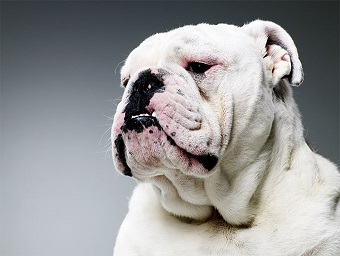

You are a dog and you look like a Bulldog.


In [63]:
filename = './testImages/bulldog.jpg'
img = Image(filename) 
display(img)
print(predict_img(filename))

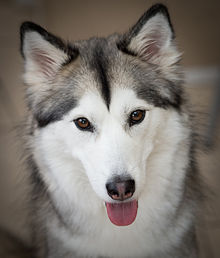

You are a dog and you look like a Alaskan_malamute.


In [64]:
filename = './testImages/siberian_husky.jpg'
img = Image(filename) 
display(img)
print(predict_img(filename))

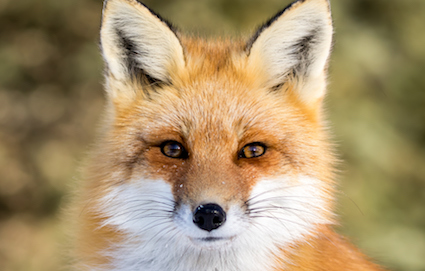

You are neither dog nor human


In [65]:
filename = './testImages/fox.jpg'
img = Image(filename) 
display(img)
print(predict_img(filename))

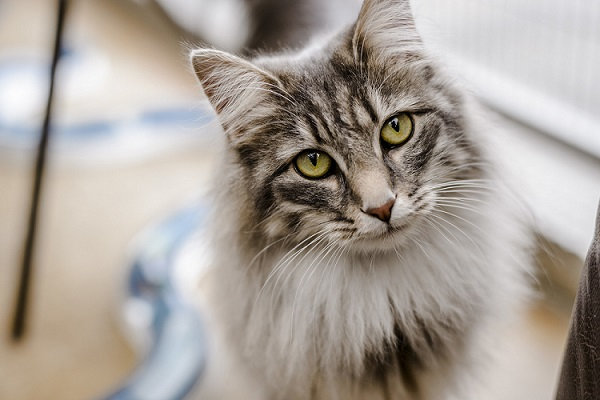

You are neither dog nor human


In [66]:
filename = './testImages/cat.jpg'
img = Image(filename) 
display(img)
print(predict_img(filename))

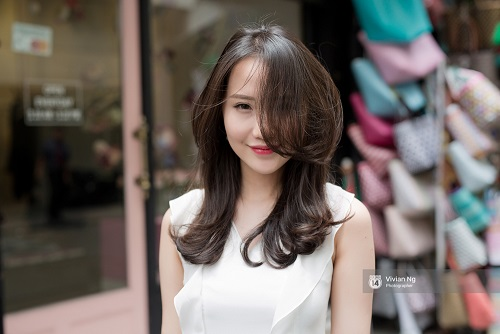

You are a human and you look like a Dachshund.


In [67]:
filename = './testImages/xuanthao.jpg'
img = Image(filename) 
display(img)
print(predict_img(filename))

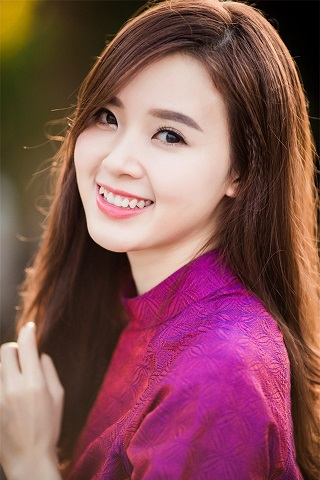

You are a human and you look like a Dachshund.


In [68]:
filename = './testImages/midu.jpg'
img = Image(filename) 
display(img)
print(predict_img(filename))

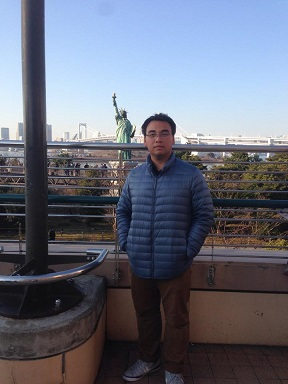

You are a human and you look like a Dachshund.


In [69]:
filename = './testImages/tamminh.jpg'
img = Image(filename) 
display(img)
print(predict_img(filename))

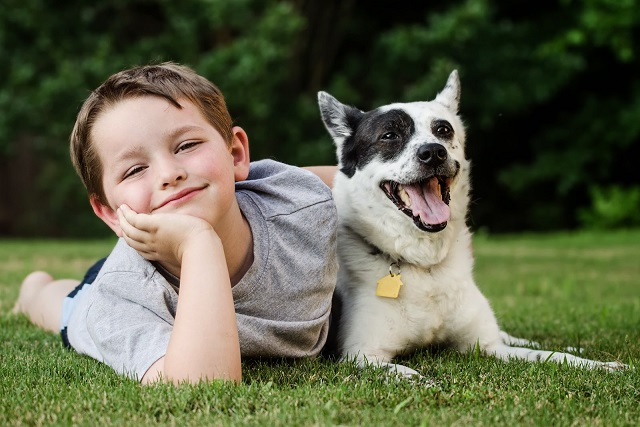

You are a dog and you look like a Akita.


In [80]:
filename = './testImages/human_dog.jpg'
img = Image(filename) 
display(img)
print(predict_img(filename))